# Sequence Analysis and Functional Prediction Pipeline

## 1. Introduction
This notebook analyzes the functional and sequence relationships between newly identified bacteria and known corrosion-influencing microorganisms. The analysis builds upon previous findings where:
- Statistical significance was established between the selected bacteria and corrosion risk (Notebook 3)
- Literature validation confirmed corrosion influence for many bacteria (Notebook 4)
- Evolutionary relationships were mapped through phylogenetic analysis (Notebook 5)

The study focuses on bacteria from operational heating and cooling water systems, primarily in Germany. Using 16S rRNA data (bootstrap-validated from Notebook 5), this analysis employs PICRUSt2 to predict metabolic functions and compare functional profiles between different bacterial groups.

### Analysis Approaches
We implement two classification strategies:

1. Simple Classification:
   - Known corrosion-causing bacteria (usual_taxa)
   - Other bacteria (combining checked_taxa and core_taxa)

2. Detailed Classification:
   - Known corrosion-causing bacteria (usual_taxa)
   - Pure checked bacteria (exclusive to checked_taxa)
   - Pure core bacteria (exclusive to core_taxa)
   - Checked-core bacteria (overlap between checked and core taxa)

This detailed approach allows for more nuanced analysis of functional profiles and better understanding of potential corrosion mechanisms across different bacterial groups.

### Analysis Goals:
- Predict metabolic functions from 16S sequences
- Focus on corrosion-relevant pathways (sulfur/iron metabolism)
- Compare functional profiles between known corrosion-causing bacteria and newly identified candidates
- Validate whether statistical correlations reflect genuine metabolic capabilities associated with corrosion processes

### Directory Structure:
 Following is the structure of the notebook data named data_picrus  
data_tree  
 ├── sequences/  
 │   ├── known.fasta : sequences of known corrosion-causing bacteria  
 │   ├── candidate.fasta : sequences of potential new corrosion-causing bacteria  
 |   └── other files  
 data_picrus  
 └── picrust_results/  
      ├── known_bacteria/  
      |               ├── EC_predictions/       : enzyme predictions  
      |               ├── pathway_predictions/  : metabolic pathway abundance  
      |               ├── KO_predictions/       : KEGG ortholog predictions  
      |               └── other_picrust_files/  
      ├── candidate_bacteria/  
      |               ├── EC_predictions/       : enzyme predictions  
      |               ├── pathway_predictions/  : metabolic pathway abundance  
      |               ├── KO_predictions/       : KEGG ortholog predictions  
      |               └── other_picrust_files/  : final comparison summary
      ├── core_bacteria/
      |               ├── EC_predictions/       : enzyme predictions  
      |               ├── pathway_predictions/  : metabolic pathway abundance  
      |               ├── KO_predictions/       : KEGG ortholog predictions  
      |               └── other_picrust_files/  
      │      
      └── functional_comparison.xlsx  

Picrust2 works using its reference database that was installed with the package   
~/miniconda3/envs/picrust2/lib/python3.9/site-packages/picrust2/default_files/prokaryotic/pro_ref

About picrust2  
https://evomics.org/wp-content/uploads/2015/01/presentation_evomics-05-picrust_01-18-15.pdf

# 2. Loading and Preparing the Data

## 2.1 Colab Initialisation

__Importing PICRUST IN COLAB__

In [1]:
'''# Install miniconda and initialize
!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!bash Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local/miniconda3
!conda config --add channels defaults
!conda config --add channels bioconda
!conda config --add channels conda-forge
# Imports for colab
import condacolab
import sys
sys.path.append('/usr/local/miniconda3/lib/python3.7/site-packages/')

# Install PICRUSt2 and its dependencies
!conda install -c bioconda -c conda-forge picrust2=2.4.1 -y
# Verify installations
!conda list | grep picrust2'''

"# Install miniconda and initialize\n!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh\n!bash Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local/miniconda3\n!conda config --add channels defaults\n!conda config --add channels bioconda\n!conda config --add channels conda-forge\n# Imports for colab\nimport condacolab\nimport sys\nsys.path.append('/usr/local/miniconda3/lib/python3.7/site-packages/')\n\n# Install PICRUSt2 and its dependencies\n!conda install -c bioconda -c conda-forge picrust2=2.4.1 -y\n# Verify installations\n!conda list | grep picrust2"

__Mounting the Drive__

In [2]:
'''from google.colab import drive
drive.mount('/content/drive')

#change the path
os.chdir('/content/drive/My Drive/MIC/picrust')'''

"from google.colab import drive\ndrive.mount('/content/drive')\n\n#change the path\nos.chdir('/content/drive/My Drive/MIC/picrust')"

# 2.2. Importing Libraries,  Making Directories and Loading Data

In [3]:
# Standard library imports
import os
import ast
import subprocess
import logging
from datetime import datetime
import shutil
from io import StringIO
from pathlib import Path
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# Data processing imports
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.stats import spearmanr
from scipy.spatial.distance import pdist
import networkx as nx

# BIOM handling
from biom import Table
from biom.util import biom_open
from biom import load_table

In [4]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Directory Structure Definitions
SIMPLE_BASE = {
    'known': 'simple_known_mic',
    'other': 'simple_candidate_mic'
}

DETAILED_BASE = {
    'known': 'detailed_known_mic',
    'pure_checked': 'detailed_pure_checked_mic',
    'pure_core': 'detailed_pure_core_mic',
    'checked_core': 'detailed_checked_core_mic'
}

SUBDIRS = [
    'EC_predictions',
    'pathway_predictions',
    'KO_predictions',
    'other_picrust_files'
]

# Base Paths
base_dir = Path("/home/beatriz/MIC/2_Micro/data_picrust")
# Create output directory if it doesn't exist
base_dir.mkdir(parents=True, exist_ok=True)
abundance_excel= Path("/home/beatriz/MIC/2_Micro/data_Ref/merged_to_sequence.xlsx")
fasta_file = Path("/home/beatriz/MIC/2_Micro/data_qiime/results_match_gg/final_sequences_gg.fasta")
aligned_fasta = Path("/home/beatriz/MIC/2_Micro/data_qiime/results_match_gg/aligned-dna-sequences_gg.fasta")
results_file = base_dir / "functional_comparison.xlsx"
output_dir = base_dir / "picrust2_out"  # Separate output directory

The fasta file come from the Alternative Sequences finding from the Greenes Genes Database, from the taxonomy in this study made in section 7 in the 5_Sequences_qiime notebook: final_sequences_gg.fasta. Abundance dataframe come from the data from notebook 4 merged_to_sequence.xlsx sheet=core_check_usual_taxa which is a unified df between 3 different groups explained previously: cora_taxa (>20% 60 abundance features), usual_taxa (17 high literature ranking bacteria influencing corrosion) and checked_taxa (30 statistically significant to the corrosion risk label) in total 85 features. 

In [5]:
# Integrated taxa from origin genus as headers with levels 6 for the genera, 7 for the GID, muss be cleaned
Integrated_T = pd.read_excel(abundance_excel, sheet_name='core_check_usual_taxa', header=[0,1,2,3,4,5,6,7], engine ='openpyxl')
# Drop first row (index 0) and first column in one chain
Integrated_T = Integrated_T.drop(index=0).drop(Integrated_T.columns[0], axis=1)
Integrated_T= Integrated_T.astype({'Sites': str})
Integrated_T['Sites'] = Integrated_T['Sites'].fillna('Source')
# Remove 'Unnamed' level names
Integrated_T.columns = Integrated_T.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
# Changing dtypes to category whiles respecting structure
Integrated_T["Category"] = Integrated_T["Category"].astype("Int64")
Integrated_T= Integrated_T.set_index("Sites")
pre_Integrated = Integrated_T.T

In [6]:
Integrated_T.tail()

,Category,Rhodocyclales_Rhodocyclaceae_Azospira,Actinomycetales_Dermabacteraceae_Brachybacterium,Actinomycetales_Brevibacteriaceae_Brevibacterium,Erysipelotrichales_Erysipelotrichaceae_Bulleidia,Clostridiales_Clostridiaceae_Clostridium,Actinomycetales_Corynebacteriaceae_Corynebacterium,Lactobacillales_Enterococcaceae_Enterococcus,Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria,Oceanospirillales_Halomonadaceae_Halomonas,...,Actinomycetales_Propionibacteriaceae_Tessaracoccus,Clostridiales_Peptococcaceae_Thermincola,Spirochaetales_Spirochaetaceae_Treponema,Burkholderiales_Oxalobacteraceae_Oxalobacteraceae_unclassified,Burkholderiales_Comamonadaceae_Variovorax,Anaerolineales_Anaerolinaceae_Wchb1-05,Desulfobacterales_Desulfobacteraceae_Desulfobacterium,Desulfobacterales_Desulfobulbaceae_Desulfobulbus,Gallionellales_Gallionellaceae_Gallionella,Alteromonadales_Shewanellaceae_Shewanella
,,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,...,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria
,,Proteobacteria,Actinobacteria,Actinobacteria,Firmicutes,Firmicutes,Actinobacteria,Firmicutes,Firmicutes,Proteobacteria,...,Actinobacteria,Firmicutes,Spirochaetes,Proteobacteria,Proteobacteria,Chloroflexi,Proteobacteria,Proteobacteria,Proteobacteria,Proteobacteria
,,Betaproteobacteria,Actinobacteria,Actinobacteria,Erysipelotrichi,Clostridia,Actinobacteria,Bacilli,Clostridia,Gammaproteobacteria,...,Actinobacteria,Clostridia,Spirochaetes,Betaproteobacteria,Betaproteobacteria,Anaerolineae,Deltaproteobacteria,Deltaproteobacteria,Betaproteobacteria,Gammaproteobacteria
,,Rhodocyclales,Actinomycetales,Actinomycetales,Erysipelotrichales,Clostridiales,Actinomycetales,Lactobacillales,Thermoanaerobacterales,Oceanospirillales,...,Actinomycetales,Clostridiales,Spirochaetales,Burkholderiales,Burkholderiales,Anaerolineales,Desulfobacterales,Desulfobacterales,Gallionellales,Alteromonadales
,,Rhodocyclaceae,Dermabacteraceae,Brevibacteriaceae,Erysipelotrichaceae,Clostridiaceae,Corynebacteriaceae,Enterococcaceae,Thermoanaerobacteraceae,Halomonadaceae,...,Propionibacteriaceae,Peptococcaceae,Spirochaetaceae,Oxalobacteraceae,Comamonadaceae,Anaerolinaceae,Desulfobacteraceae,Desulfobulbaceae,Gallionellaceae,Shewanellaceae
,,Azospira,Brachybacterium,Brevibacterium,Bulleidia,Clostridium,Corynebacterium,Enterococcus,Gelria,Halomonas,...,Tessaracoccus,Thermincola,Treponema,Oxalobacteraceae_unclassified,Variovorax,Wchb1-05,Desulfobacterium,Desulfobulbus,Gallionella,Shewanella
,,110,140,145,154,214,229,300,334,354,...,715,719,731,853,863,867,264,265,332,656
Sites,,,,,,,,,,,,,,,,,,,,,
site_67,3,0.004886,0,0,0,0,0,0,0,0.942935,...,0,0,0,0,0.151456,0,0,0,0,0.004886
site_68,3,0,0.021172,0,0,0,0,0,0,28.889007,...,0,0,0,0,0,0,0,0,0,0.005293


## 2.3. Making Sequences for Picrust fasta file

Picrust Functional Analyiss requires a biom table with otus as index, samples as headers and abundance as values. The present biom has genus names but is needs instead Otus instead. The other input file for picrust is the representative sequences table that consist of the sequences per genera followed by the frequency of that genera on the whole sample, this is done directly by the software. The fasta file requires the otus instead of the genera names and the sequences non aligned coming from notebook 5. The following scrips will formate the data to picrust.

In [7]:
# Read and modify sequences
new_records = []
for record in SeqIO.parse(fasta_file, "fasta"):
    # Get just the OTU number and ignore genus name
    otu_id = record.description.split()[1]  # Takes second element (the OTU number)
    
    # Create new record with only OTU as ID
    new_record = SeqRecord(
        record.seq,
        id=otu_id,
        description=""  # Empty description to keep only ID
    )
    new_records.append(new_record)

# Write modified FASTA
sequences_for_picrust = Path("/home/beatriz/MIC/2_Micro/data_picrust/sequences_for_picrust.fasta")
SeqIO.write(new_records, sequences_for_picrust, "fasta")

85

In [8]:
SeqIO.write(new_records, sequences_for_picrust, "fasta")

85

## 2.4. Making of Dataframes for 2 Different Pipelines
The following script is the path to the biom file but also to the Integrate dataframe which create dataframes that discriminate its origin in order to pass then through picrust different pipelines, to know: Simple_Base that compares the known bacteria namely usual_taxa against the other features to understand their relationships on the function of their metabolism, an additional group is put forward as simply_candidate_mic which corresponds to the bacteria no previously linked to corrosion but showing an statistical significance with the risk label, those come from the checked_taxa and in this study are: genera(GID): Bulleida (154); Mycoplana (471), Oxobacter (512) and Oerskovia (). Also as showing an favor behaviour against corrosion are presented: Phenylobacterium (549), Gelria(334), Porphyrobacteria (564) and Tepidimonas (712)
SIMPLE_BASE = {'known': 'simple_known_mic', 'other': 'simple_candidate_mic'}
The second pipeline comprises a more detailed separation of the bacteria and that is: The Known bacteria as previously, pure_checked corresponding to the statistical significant genera, pure_core correspondent to the core taxa on the systems and the combination of the core and checked taxa. 
DETAILED_BASE = {'known': 'detailed_known_mic','pure_checked': 'detailed_pure_checked_mic',
    'pure_core': 'detailed_pure_core_mic', 'checked_core': 'detailed_checked_core_mic'}

__Making the Integrated dataframe__
The original dataframe has a column for source, indicating from which df  came from (core, usual, checked), this script proceses that datadrame into individual dfs and the combined preserving the source for further analysis. The Integrated dataframe continues to be process on the next step to become the biom abundance df.

In [9]:
def process_integrated_data(df):
    """
    Process the integrated DataFrame to create a new DataFrame with clear column names
    and preserve all values including source information.

    Parameters:
    df (pandas.DataFrame): Input DataFrame with MultiIndex index and site columns

    Returns:
    pandas.DataFrame: Processed DataFrame with clear structure
    """

    # Extract genera and GIDs from the index MultiIndex
    genera = df.index.get_level_values(6)[1:]  # Skip first row
    gids = pd.to_numeric(df.index.get_level_values(7)[1:], errors='coerce')

    # Create a new DataFrame with the extracted information
    result_df = pd.DataFrame({
        'Genus': genera,
        'GID': gids
    })

    # Add the site values from the original DataFrame
    for col in df.columns:
        result_df[col] = df.iloc[1:][col].values

    # Clean up the DataFrame
    result_df['GID'] = pd.to_numeric(result_df['GID'], errors='coerce')
    result_df = result_df.dropna(subset=['GID'])
    result_df['GID'] = result_df['GID'].astype(int)

    return result_df

def get_taxa_groups(df):
    """
    Separate the processed DataFrame into different taxa groups based on Source column

    Parameters:
    df (pandas.DataFrame): Processed DataFrame from process_integrated_data()

    Returns:
    dict: Dictionary containing DataFrames for different taxa groups
    """
    # Split the data into groups based on 'Source' column patterns
    
    # Known corrosion bacteria (any pattern with 'us')
    known_bacteria = df[df['Source'].str.contains('us', case=False, na=False)]

    # Pure checked bacteria (only 'chk' without 'core' or 'us')
    pure_checked = df[
        df['Source'].str.contains('chk', case=False, na=False) &
        ~df['Source'].str.contains('core|us', case=False, na=False)
    ]

    # Pure core bacteria (only 'core' without 'chk' or 'us')
    pure_core = df[
        df['Source'].str.contains('core', case=False, na=False) &
        ~df['Source'].str.contains('chk|us', case=False, na=False)
    ]

    # Checked-core bacteria (contains both 'core' and 'chk' but no 'us')
    checked_core = df[
        df['Source'].str.contains('chk.*core|core.*chk', case=False, na=False) &
        ~df['Source'].str.contains('us', case=False, na=False)
    ]

    # Create groups dictionary
    taxa_groups = {
        'known_bacteria': known_bacteria,
        'pure_checked': pure_checked,
        'pure_core': pure_core,
        'checked_core': checked_core
    }

    # Print summary statistics
    print("\nDetailed Classification Results:")
    print(f"Known corrosion bacteria: {len(known_bacteria)}")
    print(f"Pure checked bacteria: {len(pure_checked)}")
    print(f"Pure core bacteria: {len(pure_core)}")
    print(f"Checked-core bacteria: {len(checked_core)}")

    # Verify total matches expected
    total_classified = len(known_bacteria) + len(pure_checked) + len(pure_core) + len(checked_core)
    print(f"\nTotal classified taxa: {total_classified}")
    print(f"Total in dataset: {len(df)}")

    return taxa_groups

# Usage example:
Integrated = process_integrated_data(pre_Integrated)

# Get the groups
taxa_groups = get_taxa_groups(Integrated)

# Access individual groups -
known_bacteria = taxa_groups['known_bacteria']
pure_core = taxa_groups['pure_core']
pure_checked = taxa_groups['pure_checked']
checked_core = taxa_groups['checked_core']


Detailed Classification Results:
Known corrosion bacteria: 17
Pure checked bacteria: 19
Pure core bacteria: 46
Checked-core bacteria: 3

Total classified taxa: 85
Total in dataset: 85


## 2.5. Making the Abundanc Biom dataframe for Picrust

The final biom should have as index the Otus numbers no the genera names and a clean formate

In [10]:
# droping source and genus and putting GID as index
pre_biom= Integrated.drop(columns=["Source", "GID"])
pre_biom= pre_biom.set_index("Genus").astype(str)
# Ensure all data values are float
pre_biom = pre_biom.astype(float)

__changing genera to otus__

In [11]:
# Create genus to OTU mapping from FASTA headers
genus_to_otu = {}
for record in SeqIO.parse("/home/beatriz/MIC/2_Micro/data_qiime/results_match_gg/final_sequences_gg.fasta", "fasta"):
    parts = record.description.split()
    if len(parts) >= 3:
        genus = parts[0]
        otu = parts[1]  # We'll use the first OTU number
        genus_to_otu[genus] = otu

'''# Print a few mappings to verify
print("Sample genus to OTU mappings:")
for i, (genus, otu) in enumerate(list(genus_to_otu.items())[:5]):
    print(f"{genus} -> {otu}")'''

# Replace genus with OTU in the index
pre_biom.index = pre_biom.index.map(lambda x: genus_to_otu.get(x, x))

# Remove the 'Genus' name from the index
pre_biom.index.name = "OTU"


In [12]:
print(pre_biom.head())

            site_1   site_2    site_3    site_4    site_5  site_6    site_7  \
OTU                                                                           
690515   26.928048  1.85923  3.093543  2.573991  2.709369     0.0  2.146235   
519902    0.000000  0.00000  0.000000  0.000000  0.000000     0.0  0.000000   
1134896   0.000000  0.00000  0.000000  0.000000  0.000000     0.0  0.000000   
336037    0.000000  0.00000  0.000000  0.000000  0.000000     0.0  0.000000   
1124194   0.000000  0.00000  0.000000  0.000000  0.000000     0.0  0.000000   

         site_8   site_9  site_10  ...   site_61   site_62   site_63  site_64  \
OTU                                ...                                          
690515     0.54  3.90318      0.0  ...  0.353291  0.571304  0.624133     0.26   
519902     0.00  0.00000      0.0  ...  0.000000  0.000000  0.000000     0.00   
1134896    0.00  0.00000      0.0  ...  0.000000  0.000000  0.000000     0.00   
336037     0.00  0.00000      0.0  ...  0

In [13]:
print(*pre_biom.index.tolist())

690515 519902 1134896 336037 1124194 1042616 543824 4405849 716727 838066 2651333 1125570 355750 89388 4320905 4379512 586332 370584 4328978 4303453 4449524 4326986 270098 562023 523025 546567 147946 4366937 220314 581747 141042 4362609 313427 4439125 239470 277409 2251859 259272 329940 4312850 866365 219549 341885 258617 156371 10413 4424709 4450598 4308446 823916 4345999 4010666 4354822 3275744 530377 676387 4422405 4303815 1777569 652276 1688393 104313 605399 4345543 339616 181537 781203 1657324 120274 713656 1125313 3290764 722895 928538 145205 529182 4337055 3918 236204 38267 4463039 556957 162379 638460 4378477


__Calculation counts for picrust2__

In [14]:
scaling_factor = 10000
# Multiply by scaling factor and round to nearest integer
count_pre_biom = np.round(pre_biom * scaling_factor).astype(int)
count_pre_biom 

,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,site_9,site_10,...,site_61,site_62,site_63,site_64,site_65,site_66,site_67,site_68,site_69,site_70
OTU,,,,,,,,,,,,,,,,,,,,,
690515,269280,18592,30935,25740,27094,0,21462,5400,39032,0,...,3533,5713,6241,2600,45182,4000,49,0,14700,17200
519902,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,544,0,0,212,0,0
1134896,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2177,0,0,0,0,0
336037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1124194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5444,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4463039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,7621,0,0,0,0,0
556957,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162379,1723,190,0,66,184,0,461,0,89,0,...,0,1439,1156,0,25585,0,0,0,0,0


__Creating the biom table formate__

In [15]:
# Create BIOM table with type specification
biom_table = Table(data=count_pre_biom.values,
                  observation_ids=count_pre_biom.index.astype(str),
                  sample_ids=count_pre_biom.columns.astype(str),
                  type="OTU table",
                  create_date=datetime.now().isoformat(),
                  generated_by="BIOM-Format",
                  matrix_type="sparse",
                  matrix_element_type="float")

# Save with explicit format
output_path = "/home/beatriz/MIC/2_Micro/data_picrust/count_abundance_85.biom"
with biom_open(output_path, 'w') as f:
    biom_table.to_hdf5(f, generated_by="BIOM-Format")

# Validate the table structure
print("\nValidating table...")
!biom validate-table -i /home/beatriz/MIC/2_Micro/data_picrust/count_abundance_85.biom

# Show table info
!biom summarize-table -i /home/beatriz/MIC/2_Micro/data_picrust/count_abundance_85.biom


Validating table...

The input file is a valid BIOM-formatted file.
Num samples: 70
Num observations: 85
Total count: 56747993
Table density (fraction of non-zero values): 0.405

Counts/sample summary:
 Min: 181800.000
 Max: 990578.000
 Median: 851078.500
 Mean: 810685.614
 Std. dev.: 157876.192
 Sample Metadata Categories: None provided
 Observation Metadata Categories: None provided

Counts/sample detail:
site_69: 181800.000
site_67: 217903.000
site_70: 270600.000
site_26: 582999.000
site_21: 589725.000
site_5: 606497.000
site_4: 637258.000
site_56: 658582.000
site_32: 668615.000
site_28: 690377.000
site_46: 711571.000
site_61: 713651.000
site_6: 721400.000
site_68: 729848.000
site_3: 731035.000
site_9: 738359.000
site_1: 742781.000
site_38: 748832.000
site_36: 776928.000
site_10: 778900.000
site_58: 785781.000
site_22: 795027.000
site_2: 798524.000
site_33: 799298.000
site_13: 801502.000
site_34: 810400.000
site_63: 813452.000
site_59: 814977.000
site_30: 819289.000
site_62: 828999

# 3. Making the representative sequences

__Convert Abundance Biom table and the Sequences into a QIIME2 artifact__

In [16]:
def create_rep_seqs_with_freq(sequence_file, pre_biom_df, output_fasta):
    """
    Create representative sequences with frequencies written to output
    
    Args:
        sequence_file: Path to FASTA file with OTU sequences
        pre_biom_df: DataFrame with abundance data 
        output_fasta: Path to save sequences with frequencies
    """
    # Calculate total frequency for each OTU
    total_frequencies = round(pre_biom_df.sum(axis=1), 2)
    
    with open(output_fasta, 'w') as out:
        for record in SeqIO.parse(sequence_file, "fasta"):
            otu_id = record.id
            
            if otu_id in total_frequencies.index:
                freq = total_frequencies[otu_id]
                sequence = str(record.seq)
                
                # Write sequence with frequency to FASTA
                out.write(f">{otu_id} {sequence} {freq}\n")

    # Show example of what was written
    print("Example of FASTA output format:")
    with open(output_fasta, 'r') as f:
        for i, line in enumerate(f):
            if i < 6:  # Show first 3 sequences (header + sequence lines)
                print(line.strip())

# Representative sequences
'''sequences_for_picrust = Path("/home/beatriz/MIC/2_Micro/data_picrust/sequences_for_picrust.fasta")
output_fasta = Path("/home/beatriz/MIC/2_Micro/data_picrust/rep_seqs_with_freq.fasta")
create_rep_seqs_with_freq(sequences_for_picrust, pre_biom, output_fasta)'''

'sequences_for_picrust = Path("/home/beatriz/MIC/2_Micro/data_picrust/sequences_for_picrust.fasta")\noutput_fasta = Path("/home/beatriz/MIC/2_Micro/data_picrust/rep_seqs_with_freq.fasta")\ncreate_rep_seqs_with_freq(sequences_for_picrust, pre_biom, output_fasta)'

__Disclamer:__ These notebook was mean to do the analysis of the functional mechanisms of bacteria using picrust2, however the capacity of the laptop was no sufficient to run it, nor colab on public library, nor a virtual machine, that is the reason why the analysis was undertaken in the galaxy website, where the data resides.
https://usegalaxy.eu/  
username= magicalex238

## 3.1. Classifying Bacteria by their Source DataFrame
Two distinct classification approaches are implemented to categorize bacteria. The simple approach (get_bacteria_sources_simple) divides bacteria into known corrosion-causers (usual_taxa) and candidates (all others). The detailed approach (get_bacteria_sources_detailed) provides finer categorization by separating bacteria into known corrosion-causers, pure checked taxa, pure core taxa, and those present in both checked and core datasets. Please notice that this function uses df Integrated for source clasification and no abundance.biom which will be used for the picrust2 pipeline.

In [17]:
def get_bacteria_sources_simple(Integrated_df):
    """
    Simple classification:
    1. Known (anything with 'us')
    2. All others (combined chk, core, chk-core)
    """
    # Get genera and gids from column levels 6 and 7
    genera = Integrated_df["Genus"]
    gids = Integrated_df["GID"]
    # Look for Source in the data, not index
    sources = Integrated_df['Source'] if 'Source' in Integrated_df.columns else None

    known_bacteria = {}     # usual_taxa
    other_bacteria = {}     # everything else

    sources_found = set()
    source ={}
    patterns = ['us', 'core-us', 'chk-us', 'chk-core-us']

    for i, (genus, gid) in enumerate (zip(genera, gids)):
        if source is not None:  # Check if source exists for this genus
            source = str(sources.iloc[i]).strip().lower()
            sources_found.add(source)

            if source in patterns:
                known_bacteria[genus] = int(gid) if str(gid).isdigit() else gid
            else:
                other_bacteria[genus] = int(gid) if str(gid).isdigit() else gid

    print("\nSimple Classification Results:")
    print(f"Known corrosion bacteria: {len(known_bacteria)}")
    print(f"Other bacteria: {len(other_bacteria)}")
    print("\nSources found:", sources_found)

    return {
        'known_bacteria': known_bacteria,
        'other_bacteria': other_bacteria
    }

def get_bacteria_sources_detailed(Integrated_df):
    """
    Detailed classification with all possible combinations:
    1. Known (usual_taxa)
    2. Pure checked (only 'chk')
    3. Pure core (only 'core')
    4. Checked-core (overlap 'chk-core')
    """
    # Get genera and gids from column levels 6 and 7
    genera = Integrated_df.index.get_level_values(6)[1:]
    gids = Integrated_df.index.get_level_values(7)[1:]

    sources = Integrated_df['Source'] if 'Source' in Integrated_df.columns else None

    known_bacteria = {}      # usual_taxa
    pure_checked = {}        # only 'chk' checked_taxa
    pure_core = {}          # only 'core' core_taxa
    checked_core = {}       # 'chk-core' checked and core taxa
    source ={}
    sources_found = set()
    patterns = ['us', 'core-us', 'chk-us', 'chk-core-us']

    for i, (genus, gid) in enumerate (zip(genera, gids)):
        if source is not None:  # Check if source exists for this genus
            source = str(sources.iloc[i]).strip().lower()
            sources_found.add(source)

            if source in patterns:
                known_bacteria[genus] = int(gid) if str(gid).isdigit() else gid
                continue

            # Then handle other combinations
            if source == 'chk':
                pure_checked[genus] = gid
            elif source == 'core':
                pure_core[genus] = gid
            elif 'chk-core' in source:
                checked_core[genus] = gid

    print("\nDetailed Classification Results:")
    print(f"Known corrosion bacteria: {len(known_bacteria)}")
    print(f"Pure checked bacteria: {len(pure_checked)}")
    print(f"Pure core bacteria: {len(pure_core)}")
    print(f"Checked-core bacteria: {len(checked_core)}")
    print("\nSources found:", sources_found)

    return {
        'known_bacteria': known_bacteria,
        'pure_checked': pure_checked,
        'pure_core': pure_core,
        'checked_core': checked_core
    }

## 3.2. Prepare picrust data and Creating Directories for PICRUSt2 Input
The check_missing_genera function processes the integrated data and handles data quality control. Known problematic genera (e.g., 'Clostridium_sensu_stricto_12', 'Oxalobacteraceae_unclassified') are flagged for exclusion to prevent analysis errors. The function also creates an organized directory structure as outlined in the introduction, with separate paths for different bacterial classifications (known_mic, candidate_mic, etc.) and their respective analysis outputs (EC_predictions, pathway_predictions, KO_predictions). Following function prepares the data for picrust analysis but both dataframes the abundance.biom and Integrated have some bacteria that were no sequenciated mostly cause are no known specimens. So it is necesary to do same procedure to both dfs.

In [18]:
def prepare_picrust_data(Integrated_df, aligned_file, function_type='simple'):
    """
    Prepare data for PICRUSt analysis with choice of  function_type method

    Args:
        Integrated_df: Input DataFrame
        aligned_file: Path to aligned sequences
        function_type: 'simple' or 'detailed'
    """
    # Get bacteria source_groups based on chosen  function_type
    if  function_type == 'simple':
        source_groups = get_bacteria_sources_simple(Integrated_df)
    else:
        source_groups= get_bacteria_sources_detailed(Integrated_df)

    # Create appropriate directory structure
    create_directory_structure(function_type)

    return source_groups

def create_directory_structure(function_type='simple'):
    """Create directory structure for PICRUSt analysis"""
    base_dir = Path("/home/beatriz/MIC/2_Micro/data_picrust")
    base_dir.mkdir(parents=True, exist_ok=True)

    if function_type == 'simple':
        directories = SIMPLE_BASE
    else:
        directories = DETAILED_BASE

    # Create all required directories
    for dir_name in directories.values():
        for subdir in SUBDIRS:
            (base_dir / dir_name / subdir).mkdir(parents=True, exist_ok=True)
    logging.info("Directory structure created successfully")
    return True

'''except Exception as e:
    logging.error(f"Error creating directory structure: {str(e)}")
    return False'''

'except Exception as e:\n    logging.error(f"Error creating directory structure: {str(e)}")\n    return False'

In [19]:
def verify_input_files():
    """Verify that input files exist and are readable"""
    missing_files = []
    
    if not fasta_file.exists():
        missing_files.append(str(fasta_file))
    if not biom_table.exists():
        missing_files.append(str(biom_table))
        
    if missing_files:
        logging.error(f"Missing input files: {', '.join(missing_files)}")
        return False
    
    logging.info("All input files found")
    return True

# 4. PICRUSt Pipeline Definition
The pipeline processes the aligned sequence data from notebook 5 that has or not undergo cleaning of the sequences as previously done on section 2. Also processes the biom_table in order to account on this anylsis on abundance. It queries the PICRUSt database to predict potential metabolic pathways for each genus. This prediction is based on evolutionary relationships and known genomic capabilities of related organisms.

In [20]:
def run_picrust2_pipeline(fasta_file, biom_file, output_dir):
    """
    Run the main PICRUSt2 pipeline on input sequences and BIOM table.

    Args:
        fasta_file: Path to the aligned sequences FASTA file.
        biom_file: Path to the BIOM table (without extra columns).
        output_dir: Directory for PICRUSt2 output.
    """
    try:
        # Run main PICRUSt2 pipeline
        cmd = [
            'picrust2_pipeline.py',
            '-s', fasta_file,        # Input FASTA file with aligned sequences
            '-i', biom_file,         # BIOM table with abundance data
            '-o', output_dir,        # Output directory
            '--processes', '4',      # Parallel processes
            '--verbose',
            '--min_align', '0.25'    # Note the split here
        ]
        subprocess.run(cmd, check=True)

        # Add pathway descriptions if the pathway file exists
        pathway_file = os.path.join(output_dir, 'pathways_out/path_abun_unstrat.tsv.gz')
        if os.path.exists(pathway_file):
            cmd_desc = [
                'add_descriptions.py',
                '-i', pathway_file,
                '-m', 'PATHWAY',
                '-o', os.path.join(output_dir, 'pathways_with_descriptions.tsv')
            ]
            subprocess.run(cmd_desc, check=True)

        print(f"PICRUSt2 pipeline completed successfully for {output_dir}")
        return True

    except subprocess.CalledProcessError as e:
        print(f"Error running PICRUSt2: {e}")
        return False

# 5. Analysis of Pathways
The analysis focuses on metabolic pathways known to be involved in microbially influenced corrosion, including sulfur metabolism, organic acid production, iron metabolism, and biofilm formation. These pathways were selected based on documented mechanisms of known corrosion-inducing bacteria. Separate pipeline runs for simple and detailed classifications ensure proper pathway analysis for each bacterial group.

In [21]:
def analyze_functional_profiles(picrust_output_dir, bacteria_list):
    """
    Analyze functional profiles with focus on corrosion-relevant pathways

    Parameters:
    picrust_output_dir: directory containing PICRUSt2 output
    bacteria_list: list of bacteria names to analyze
    """
    # Define corrosion-relevant pathways
    relevant_pathways = [
        'Sulfur metabolism',
        'Iron metabolism',
        'Energy metabolism',
        'Biofilm formation',
        'Metal transport',
        'ochre formation',
        'iron oxide deposits',
        'iron precipitation',
        'rust formation',
        'organic acid production',
        'acetate production',
        'lactate metabolism',
        'formate production',
    ]

    try:
        # Read PICRUSt2 output
        pathway_file = os.path.join(picrust_output_dir, 'pathways_with_descriptions.tsv')
        pathways_df = pd.read_csv(pathway_file, sep='\t')

        # Filter for relevant pathways
        filtered_pathways = pathways_df[
            pathways_df['description'].str.contains('|'.join(relevant_pathways),
                                                  case=False,
                                                  na=False)]

        # Calculate pathway abundances per bacteria
        pathway_abundances = filtered_pathways.groupby('description').sum()

        # Calculate pathway similarities between bacteria
        pathway_similarities = {}
        for bacteria in bacteria_list:
            if bacteria in pathways_df.columns:
                similarities = pathways_df[bacteria].corr(pathways_df[list(bacteria_list)])
                pathway_similarities[bacteria] = similarities

        # Predict functional potential
        functional_predictions = {}
        for pathway in relevant_pathways:
            pathway_presence = filtered_pathways[
                filtered_pathways['description'].str.contains(pathway, case=False)
            ]
            if not pathway_presence.empty:
                functional_predictions[pathway] = {
                    'presence': len(pathway_presence),
                    'mean_abundance': pathway_presence.mean().mean(),
                    'max_abundance': pathway_presence.max().max()
                }

        # Calculate correlation scores
        correlation_scores = {}
        for bacteria in bacteria_list:
            if bacteria in pathways_df.columns:
                correlations = pathways_df[bacteria].corr(
                    pathways_df[filtered_pathways.index]
                )
                correlation_scores[bacteria] = {
                    'mean_correlation': correlations.mean(),
                    'max_correlation': correlations.max(),
                    'key_pathways': correlations.nlargest(5).index.tolist()
                }

        comparison_results = {
            'pathway_similarities': pathway_similarities,
            'functional_predictions': functional_predictions,
            'correlation_scores': correlation_scores,
            'pathway_abundances': pathway_abundances.to_dict()
        }

        return filtered_pathways, comparison_results

    except Exception as e:
        print(f"Error in pathway analysis: {str(e)}")
        return None, None

## 5.2. Testing the pipeline

In [22]:
'''# ---- RUNNING THE PIPELINE ----

# Set paths
fasta_file = Path('/home/beatriz/MIC/2_Micro/data_tree/accession_sequences.fasta') 
abundance_biom_file =  Path('/home/beatriz/MIC/2_Micro/data_picrust/abundance_accession.biom')
output_dir = 'picrust_output'

# List of bacteria to analyze
bacteria_of_interest = ['Azospira', 'Brachybacterium', 'Bulleidia']

# Run PICRUSt2
if run_picrust2_pipeline(aligned_fasta_file,
                         abundance_biom_file,
                         output_dir
                        ):
    # Analyze functional profiles if the pipeline completes successfully
    filtered_pathways, abundances = analyze_functional_profiles(output_dir, bacteria_of_interest)'''

"# ---- RUNNING THE PIPELINE ----\n\n# Set paths\nfasta_file = Path('/home/beatriz/MIC/2_Micro/data_tree/accession_sequences.fasta') \nabundance_biom_file =  Path('/home/beatriz/MIC/2_Micro/data_picrust/abundance_accession.biom')\noutput_dir = 'picrust_output'\n\n# List of bacteria to analyze\nbacteria_of_interest = ['Azospira', 'Brachybacterium', 'Bulleidia']\n\n# Run PICRUSt2\nif run_picrust2_pipeline(aligned_fasta_file,\n                         abundance_biom_file,\n                         output_dir\n                        ):\n    # Analyze functional profiles if the pipeline completes successfully\n    filtered_pathways, abundances = analyze_functional_profiles(output_dir, bacteria_of_interest)"

# 6. Functional Analysis
## 6.1 Running picrust full pipeline 1
The analysis workflow begins by categorizing bacteria into source groups using the classification functions. These categorized data are then processed through the PICRUSt pipeline to predict metabolic capabilities. The functional analysis examines pathway presence, abundance, and correlations between different bacterial groups to identify potential corrosion-related metabolic patterns.

In [23]:
def run_functional_analysis(df, Integrated_df, aligned_file, analysis_type='simple'):
    """
    Run complete functional analysis pipeline for either simple or detailed classification

    Parameters:
    df: Input DataFrame
    aligned_file: Path to aligned sequences file
    analysis_type: 'simple' or 'detailed'
    """
    try:
        print(f"\n{'='*50}")
        print(f"Starting {analysis_type} classification analysis")
        print(f"{'='*50}")

        # Prepare data and get source groups
        print("\nStep 1: Preparing data...")

        source_groups = prepare_picrust_data(Integrated_df, aligned_file, function_type=analysis_type)

        if not source_groups:
            raise ValueError("Failed to prepare data: No source groups returned")

        # Base directory for PICRUSt output
        base_dir = Path("/home/beatriz/MIC/2_Micro/data_picrust")

        results = {}

        if analysis_type == 'simple':
            # Run analysis for simple classification
            # Known bacteria
            known_output_dir = base_dir /SIMPLE_BASE['known']
            success_known = run_picrust2_pipeline(aligned_file, df, str(known_output_dir))
            if success_known:
                results_known = analyze_functional_profiles(str(known_output_dir),
                                                        source_groups['known_bacteria'].keys())

            # Other bacteria
            other_output_dir = base_dir / SIMPLE_BASE['other']
            success_other = run_picrust2_pipeline(aligned_file, str(other_output_dir))
            if success_other:
                results_other = analyze_functional_profiles(str(other_output_dir),
                                                        source_groups['other_bacteria'].keys())

        else:
            # Run analysis for detailed classification
            for group, dir_name in DETAILED_BASE.items():

                # Known bacteria
                known_output_dir = base_dir / DETAILED_BASE['known']
                success_known = run_picrust2_pipeline(aligned_file, str(known_output_dir))
                if success_known:
                    results_known = analyze_functional_profiles(str(known_output_dir),
                                                            source_groups['known_bacteria'].keys())

                # Pure checked bacteria
                checked_output_dir = base_dir /  DETAILED_BASE['pure_checked']
                success_checked = run_picrust2_pipeline(aligned_file, str(checked_output_dir))
                if success_checked:
                    results_checked = analyze_functional_profiles(str(checked_output_dir),
                                                            source_groups['pure_checked'].keys())

                # Pure core bacteria
                core_output_dir = base_dir /DETAILED_BASE['pure_core']
                success_core = run_picrust2_pipeline(aligned_file, str(core_output_dir))
                if success_core:
                    results_core = analyze_functional_profiles(str(core_output_dir),
                                                            source_groups['pure_core'].keys())

                # Checked-core bacteria
                checked_core_output_dir = base_dir /DETAILED_BASE['checked_core']
                success_checked_core = run_picrust2_pipeline(aligned_file, str(checked_core_output_dir))
                if success_checked_core:
                    results_checked_core = analyze_functional_profiles(str(checked_core_output_dir),
                                                                    source_groups['checked_core'].keys())
    except subprocess.CalledProcessError as e:
        print(f"Error running PICRUSt2: {e}")

        return "Analysis completed successfully"

In [24]:
'''# Run the analysis for both types
# Simple source classification
simple_results = run_functional_analysis(biom_table, aligned_file, analysis_type='simple') # output_biom

# Detailed source classification
detailed_results = run_functional_analysis(biom_table, aligned_file, analysis_type='detailed')'''

"# Run the analysis for both types\n# Simple source classification\nsimple_results = run_functional_analysis(biom_table, aligned_file, analysis_type='simple') # output_biom\n\n# Detailed source classification\ndetailed_results = run_functional_analysis(biom_table, aligned_file, analysis_type='detailed')"

## 6.2 Running picrust full pipeline 2

In [25]:
def run_picrust2_pipeline(fasta_file, output_dir, min_align =0.5):
    """
    Run PICRUSt2 pipeline with improved error handling and path management

    Args:
        fasta_file: Path to aligned sequences fasta file (str or Path)
        output_dir: Directory for PICRUSt2 output (str or Path)
    """
    import subprocess
    import os
    from pathlib import Path

    # Convert paths to strings
    fasta_file = str(fasta_file)
    output_dir = str(output_dir)

    try:
        # Verify picrust2 is available
        picrust_check = subprocess.run(['which', 'picrust2_pipeline.py'],
                                     capture_output=True,
                                     text=True)
        if picrust_check.returncode != 0:
            raise RuntimeError("picrust2_pipeline.py not found. Please ensure PICRUSt2 is properly installed.")

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

        # Construct command as a single string
        cmd = f"picrust2_pipeline.py -s {fasta_file} -i {fasta_file} -o {output_dir} --processes 1 --verbose"

        # Run pipeline
        print(f"Running command: {cmd}")
        process = subprocess.run(cmd,
                               shell=True,  # Use shell to handle command string
                               check=True,
                               capture_output=True,
                               text=True)

        print("PICRUSt2 Output:")
        print(process.stdout)

        if process.stderr:
            print("Warnings/Errors:")
            print(process.stderr)

        # Add descriptions if pathway file exists
        pathway_file = os.path.join(output_dir, 'pathways_out/path_abun_unstrat.tsv.gz')
        if os.path.exists(pathway_file):
            desc_cmd = f"add_descriptions.py -i {pathway_file} -m PATHWAY -o {os.path.join(output_dir, 'pathways_with_descriptions.tsv')}"
            subprocess.run(desc_cmd, shell=True, check=True)

        print(f"PICRUSt2 pipeline completed successfully for {output_dir}")
        return True

    except subprocess.CalledProcessError as e:
        print(f"Error running PICRUSt2 command: {e}")
        print(f"Command output: {e.output}")
        return False
    except Exception as e:
        print(f"Error in pipeline: {str(e)}")
        return False

In [26]:
'''# For original sequences
aligned_file = aligned_fasta
output_dir = Path("/home/beatriz/MIC/2_Micro/data_picrust/original_results")
success = run_picrust2_pipeline(aligned_file, output_dir)

# For improved sequences
optimized_file = Path("/home/beatriz/MIC/2_Micro/data_picrust/picrust_optimized_sequences.fasta")
optimized_output = Path("/home/beatriz/MIC/2_Micro/data_picrust/optimized_results")
success_opt = run_picrust2_pipeline(optimized_file, optimized_output)'''

'# For original sequences\naligned_file = aligned_fasta\noutput_dir = Path("/home/beatriz/MIC/2_Micro/data_picrust/original_results")\nsuccess = run_picrust2_pipeline(aligned_file, output_dir)\n\n# For improved sequences\noptimized_file = Path("/home/beatriz/MIC/2_Micro/data_picrust/picrust_optimized_sequences.fasta")\noptimized_output = Path("/home/beatriz/MIC/2_Micro/data_picrust/optimized_results")\nsuccess_opt = run_picrust2_pipeline(optimized_file, optimized_output)'

# 7. Findings and Analysis

The PICRUSt2 pipeline generated a series of interconnected files revealing the functional potential of the microbial community. These files collectively map metabolic pathways, enzymatic functions, and taxonomic relationships, providing a multi-layered view of microbial functional capabilities across samples. Detailed view of the files found in the folder ~data_picrust are located in the manuscript.

Picrust_Result_SEPP and Picrust_Result_EPA contain the descriptions, pathways and abundance of the full pipeline of picrust.

In [27]:
MetaCyc_EPA_path = Path("~/MIC/2_Micro/data_picrust/Galaxy19-[PICRUSt2 Add descriptions on data 8].tabular")
Picrust_Result= pd.read_csv(MetaCyc_EPA_path, sep = "\t")
Picrust_Result_EPA= pd.read_csv(MetaCyc_EPA_path, sep = "\t")
Picrust_Result_EPA.set_index("description", inplace=True)
Picrust_Result_EPA = Picrust_Result_EPA.drop("pathway", axis=1)
Picrust_Result_EPA.index.name = "pathway"
MetaCyc_SEPP_path = Path("~/MIC/2_Micro/data_picrust/Galaxy35-[PICRUSt2 Add descriptions on data 14].tabular")
Picrust_Result_SEPP= pd.read_csv(MetaCyc_SEPP_path, sep = "\t")
Picrust_Result_SEPP.set_index("description", inplace=True)
Picrust_Result_SEPP = Picrust_Result_SEPP.drop("pathway", axis=1)
Picrust_Result_SEPP.index.name = "pathway"

## 7.1. Placement Algorithm EPA vs SEPP
nsti_SEPP and nsti_EPA Corresponds to a sample-wide measure of how closely related the microbial taxa in that sample are to known reference genomes with two different placement algoritms.

In [28]:
nsti_path_EPA = Path("~/MIC/2_Micro/data_picrust/Galaxy13-[EC_weighted_nsti].tabular")
nsti_EPA= pd.read_csv(nsti_path_EPA, sep = "\t")
nsti_path_SEPP = Path("~/MIC/2_Micro/data_picrust/Galaxy20-[EC_weighted_nsti].tabular")
nsti_SEPP= pd.read_csv(nsti_path_SEPP, sep = "\t")

In [29]:
'''# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(nsti_EPA['sample'], nsti_EPA['weighted_NSTI'], alpha=0.5, label= "EPA", color="blue")
plt.scatter(nsti_SEPP['sample'], nsti_SEPP['weighted_NSTI'], alpha=0.5, label= "SEPP", color="purple")

# Add the threshold line
plt.axhline(y=0.15, color='black', linestyle='--', label='Threshold (0.15)')

# Customize the plot
plt.title('NSTI Values by Site')
plt.xlabel('Site')
plt.ylabel('NSTI Value')
plt.legend()

# Rotate x-axis labels if there are many samples
plt.xticks(rotation=90)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()'''

'# Create the scatter plot\nplt.figure(figsize=(10, 6))\nplt.scatter(nsti_EPA[\'sample\'], nsti_EPA[\'weighted_NSTI\'], alpha=0.5, label= "EPA", color="blue")\nplt.scatter(nsti_SEPP[\'sample\'], nsti_SEPP[\'weighted_NSTI\'], alpha=0.5, label= "SEPP", color="purple")\n\n# Add the threshold line\nplt.axhline(y=0.15, color=\'black\', linestyle=\'--\', label=\'Threshold (0.15)\')\n\n# Customize the plot\nplt.title(\'NSTI Values by Site\')\nplt.xlabel(\'Site\')\nplt.ylabel(\'NSTI Value\')\nplt.legend()\n\n# Rotate x-axis labels if there are many samples\nplt.xticks(rotation=90)\n\n# Adjust layout and display the plot\nplt.tight_layout()\nplt.show()'

Interestingly, the results are no as expected, it was though that the algorithm for placing the sequences more convenient for the present samples was SEPP because it is design specially for 16sRNA samples and diverse microbios communities, however the samples show another story. I fail to realise that the present data has been validated with the greenes genes database with the purpose of finding more compatibility with the picrust2 database, and therefore the EPA algoritm is performing much better on the all of samples using EPA placement algoritm. 

## 7.2. Explore Pathway Patterns
The pathway analysis strategy is to do a preliminar exploration before diving into specific hypotheses about organic matter metabolism and corrosion. It was chosen to start with unbiased exploratory data analysis of the PICRUSt pathways. The aim is to let the data reveal natural patterns without preconceptions. That helps to identify unexpected relationships between pathways, providing a baseline understanding of pathway distributions and relationships. This will guide subsequent targeted analyses of corrosion-relevant pathways.
The following script takes multiple perspectives in order to visualise the data without bias and let it reveal itself. We do PCA for linear patterns, NMF for modular organization, UMAP for non-linear relationships and take different clustering approaches. The aim being to look for natural Patterns without predefined categories, so that strong strong correlations can be identified regardless of pathway type. It is visualised the distribution of pathway abundances, correlation structure, hierarchical relationships and non-linear patterns

In [30]:
def explore_pathway_patterns(df):
    """
    Explore pathway patterns using multiple analytical approaches
    """
    # Standardize data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    
    results = {}
    
    # 1. Basic Statistics
    results['basic_stats'] = pd.DataFrame({
        'mean': df.mean(axis=1),
        'std': df.std(axis=1),
        'cv': df.std(axis=1) / df.mean(axis=1),
        'presence': (df > 0).mean(axis=1) * 100,
        'total_abundance': df.sum(axis=1)
    }).sort_values('total_abundance', ascending=False)
    
    # 2. PCA Dimensionality Reduction
    pca = PCA(n_components=5)
    X_pca = pca.fit_transform(scaled_data)
    results['pca'] = {
        'components': X_pca,
        'explained_variance': pca.explained_variance_ratio_,
        'loadings': pd.DataFrame(
            pca.components_.T,
            index=df.columns,
            columns=[f'PC{i+1}' for i in range(5)])}
    
    # 3 NMF for pathway modules
    nmf = NMF(n_components=5, init='random', random_state=0)
    W = nmf.fit_transform(df.clip(lower=0))
    H = nmf.components_
    results['nmf'] = {
        'W': pd.DataFrame(W, index=df.index, columns=[f'NMF{i+1}' for i in range(5)]), # Pathway contributions
        'H': pd.DataFrame(H, columns=df.columns, index=[f'NMF{i+1}' for i in range(5)]), # Sample patterns
        'reconstruction_err': nmf.reconstruction_err_ }
    
    # 4 UMAP for non-linear patterns
    umap_reducer = umap.UMAP(random_state=0)
    umap_result = umap_reducer.fit_transform(scaled_data)
    results['umap'] = pd.DataFrame(umap_result, index=df.index, columns=['UMAP1', 'UMAP2'])
    
    # 5. Multiple Clustering Approaches / Hierarchical clustering
    linkage_matrix = hierarchy.linkage(scaled_data, method='ward')
    
    # Try different numbers of clusters
    cluster_results = {}
    for n_clusters in [5, 10, 15]:
        # Hierarchical
        hc = AgglomerativeClustering(n_clusters=n_clusters)
        hc_labels = hc.fit_predict(scaled_data)
        
        # K-means
        km = KMeans(n_clusters=n_clusters, random_state=0)
        km_labels = km.fit_predict(scaled_data)
        
        cluster_results[n_clusters] = {'hierarchical': pd.Series(hc_labels, index=df.index, name='cluster'),
            'kmeans': pd.Series(km_labels, index=df.index, name='cluster')}
    
    results['clustering'] = cluster_results
    results['linkage'] = linkage_matrix
    
    # 4. Correlation Analysis/Spearman correlation for non-linear relationships
    corr_matrix = spearmanr(df.T)[0]
    results['correlation'] = pd.DataFrame(corr_matrix, index=df.index, columns=df.index)
    
    return results, X_pca

def plot_exploration_results(df, results):
    """
    Create visualizations for the exploratory analysis
    """
    # 1. Distribution of pathway abundances
    plt.figure(figsize=(12, 6))
    sns.histplot(data=results['basic_stats']['total_abundance'], bins=50)
    plt.title('Distribution of Pathway Abundances')
    plt.xlabel('Total Abundance')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
    # 2. PCA Results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 6), results['pca']['explained_variance'], 'bo-')
    plt.title('PCA Explained Variance')
    plt.xlabel('Component')
    plt.ylabel('Explained Variance Ratio')
    
    plt.subplot(1, 2, 2)
    plt.scatter(results['pca']['components'][:, 0], 
                results['pca']['components'][:, 1], 
                alpha=0.6)
    plt.title('PCA First Two Components')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.tight_layout()
    plt.show()
    
    # 3. UMAP visualization
    plt.figure(figsize=(10, 8))
    umap_df = results['umap']
    plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], alpha=0.6)
    plt.title('UMAP Projection of Pathways')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.tight_layout()
    plt.show()
    
    # 4. Hierarchical clustering dendrogram
    plt.figure(figsize=(15, 10))
    hierarchy.dendrogram(results['linkage'], 
                        labels=df.index,
                        leaf_rotation=90,
                        leaf_font_size=8)
    plt.title('Pathway Clustering Dendrogram')
    plt.tight_layout()
    plt.show()
    
    # 5. Correlation heatmap
    plt.figure(figsize=(12, 12))
    mask = np.triu(np.ones_like(results['correlation']))
    sns.heatmap(results['correlation'],
                mask=mask,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1)
    plt.title('Pathway Correlation Heatmap')
    plt.tight_layout()
    plt.show()

def identify_key_patterns(df, results):
    """
    Identify and summarize key patterns in the data
    """
    patterns = {}
    
    # Find highly correlated pathway groups
    corr = results['correlation']
    high_corr = pd.DataFrame(
        [(i, j, corr.loc[i,j])
         for i in corr.index
         for j in corr.index
         if i < j and abs(corr.loc[i,j]) > 0.8],
        columns=['pathway1', 'pathway2', 'correlation']
    ).sort_values('correlation', ascending=False)
    
    # Find pathways with strong PCA loadings
    loadings = results['pca']['loadings']
    strong_loadings = pd.DataFrame({
        'PC1_contribution': abs(loadings['PC1']),
        'PC2_contribution': abs(loadings['PC2'])
    }).sort_values('PC1_contribution', ascending=False)
    
    patterns['high_correlations'] = high_corr
    patterns['strong_loadings'] = strong_loadings
    
    return patterns

In [31]:
'''# Calling the function for the pipeline using EPA algoritm
results_patterns_SEPP, X_pca_SEPP = explore_pathway_patterns(Picrust_Result_SEPP)
plot_exploration_results(Picrust_Result_SEPP, results_patterns_SEPP)
patterns_SEPP = identify_key_patterns(Picrust_Result_SEPP, results_patterns_SEPP)'''

'# Calling the function for the pipeline using EPA algoritm\nresults_patterns_SEPP, X_pca_SEPP = explore_pathway_patterns(Picrust_Result_SEPP)\nplot_exploration_results(Picrust_Result_SEPP, results_patterns_SEPP)\npatterns_SEPP = identify_key_patterns(Picrust_Result_SEPP, results_patterns_SEPP)'

In [32]:
'''# Calling the function for the pipeline using EPA algoritm
results_patterns_EPA, X_pca_EPA = explore_pathway_patterns(Picrust_Result_EPA)
plot_exploration_results(Picrust_Result_EPA, results_patterns_EPA)
patterns_EPA = identify_key_patterns(Picrust_Result_EPA, results_patterns_EPA)'''

'# Calling the function for the pipeline using EPA algoritm\nresults_patterns_EPA, X_pca_EPA = explore_pathway_patterns(Picrust_Result_EPA)\nplot_exploration_results(Picrust_Result_EPA, results_patterns_EPA)\npatterns_EPA = identify_key_patterns(Picrust_Result_EPA, results_patterns_EPA)'

__Discussing first results__

The distribution of pathway abundances shows a typical microbial community pattern with few dominant pathways, suggesting key metabolic processes are essential across samples. PCA analysis reveals that only two components explain over 80% of the variance, indicating that metabolism in these systems might be driven by two major functional groups. The UMAP visualization confirms this binary pattern through two distinct clusters, demonstrating the robustness of this separation across different dimensional reduction techniques. The hierarchical clustering dendrogram further validates this division by showing two major branches, which notably align with previously observed physicochemical patterns in our Pourbaix plot analysis. The correlation heatmap exhibits strong relationships between specific pathway groups, suggesting coordinated metabolic activities that require detailed pathway mapping for full biological interpretation. EPA sequence placement shows much better differenciation on the pc plot.

## 7.3. Distribution of pathway abundances and Heatmap Hierarchies
In the following script we map the column pathway on the dataframe Picrust_Result_raw to the actual names provided by the Galaxy website that corresponds to the MetaCyc pathways. We will end up with the original Picrust_Results df with disernible names.After the 20 most abundant pathways will be plotted and the heatmap with the hierarchichal pathways drawn.

In [33]:
# Define category dict outside so that all charts can use same dict

category_dict = Integrated_T.T.iloc[0, 0:-1].to_dict()

# Define colors and categories
category_colors = {1: '#008800',  # Dark green
                   2: '#FF8C00',  # Dark orange    
                   3: '#FF0000'}   # Red
    
categories = {1: 'Normal Operation',
              2: 'Early Warning',
              3: 'System Failure'}

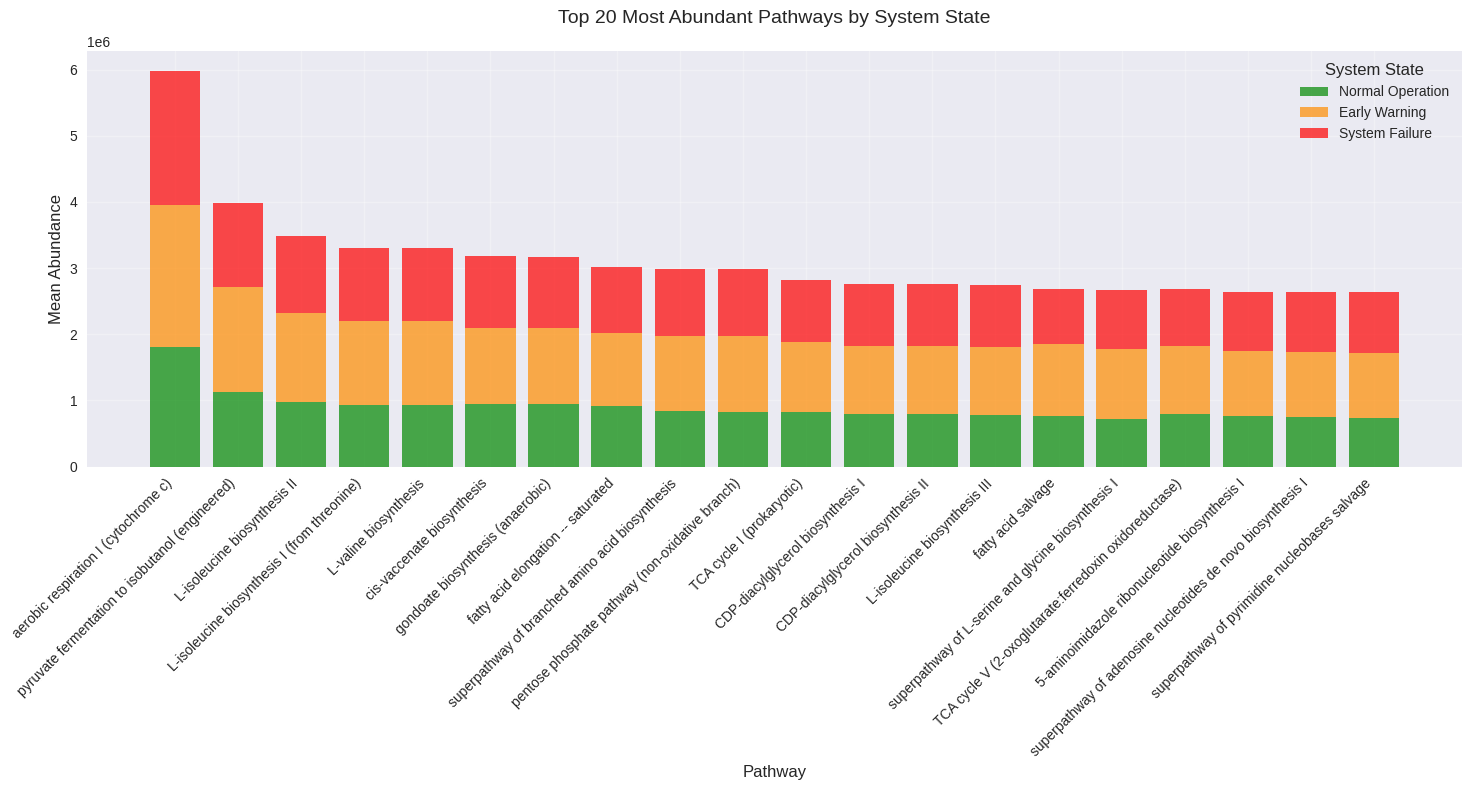

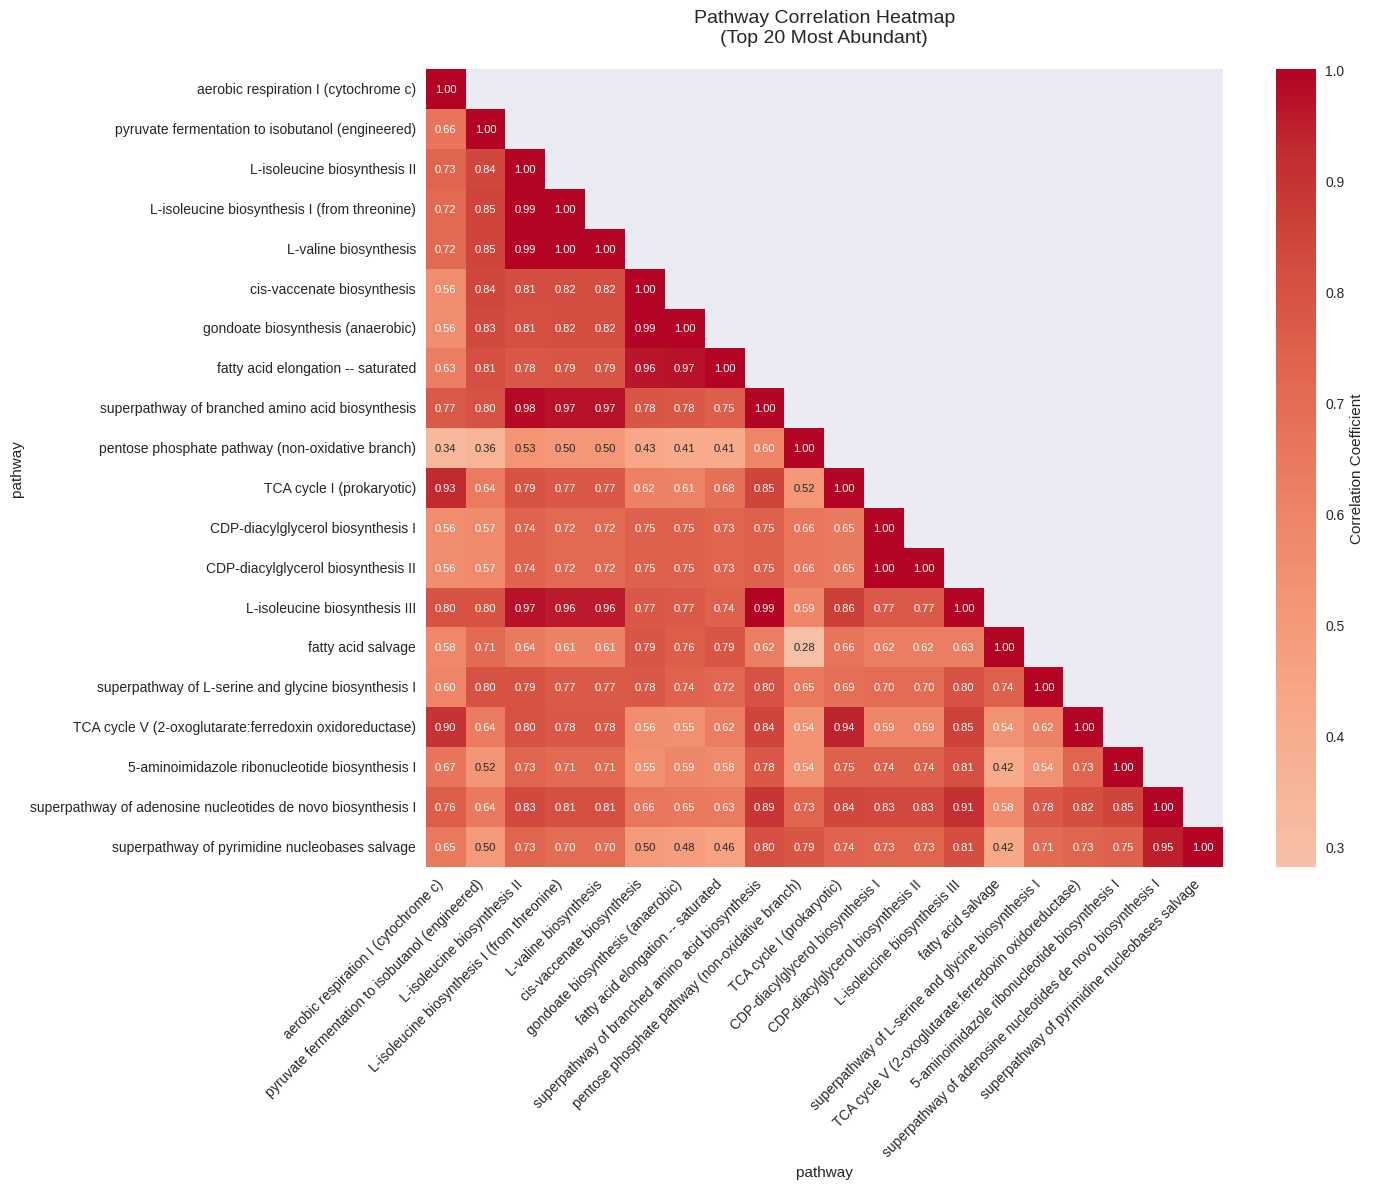

In [34]:
def analyze_pathway_patterns(df, mean_abundances, category_dict, top_n=20):
    """
    Create two separate visualizations for pathway analysis:
    1. Stacked bar chart of top pathways by system state
    2. Correlation heatmap of top pathways
    
    Parameters:
    df: DataFrame with pathway data
    mean_abundances: Series with pre-calculated mean abundances
    category_dict: Dictionary mapping sites to risk categories
    top_n: Number of top pathways to display
    """
    # Get top pathways
    top_pathways = mean_abundances.nlargest(top_n)
    
    # 1. Stacked Bar Chart
    plt.figure(figsize=(15, 8))
    
    # Prepare data for stacking
    pathway_data = []
    for pathway in top_pathways.index:
        cat_means = {}
        for cat in [1, 2, 3]:
            cat_sites = [site for site, c in category_dict.items() if c == cat]
            if cat_sites:
                cat_means[cat] = df.loc[pathway, cat_sites].mean()
            else:
                cat_means[cat] = 0
        pathway_data.append((pathway, cat_means))
    
    # Create stacked bars
    bottoms = np.zeros(len(top_pathways))
    for cat in [1, 2, 3]:
        values = [d[1][cat] for d in pathway_data]
        plt.bar(range(len(top_pathways)), values, bottom=bottoms,
                label=categories[cat], color=category_colors[cat], alpha=0.7)
        bottoms += values
    
    plt.title('Top 20 Most Abundant Pathways by System State', fontsize=14, pad=20)
    plt.xlabel('Pathway', fontsize=12)
    plt.ylabel('Mean Abundance', fontsize=12)
    plt.xticks(range(len(top_pathways)), top_pathways.index, 
               rotation=45, ha='right', fontsize=10)
    plt.legend(title='System State', title_fontsize=12, fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 2. Correlation Heatmap (separate figure)
    plt.figure(figsize=(15, 12))
    top_data = df.loc[top_pathways.index]
    corr = top_data.T.corr()
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr), k=1)
    
    # Create heatmap with improved readability
    sns.heatmap(corr, 
                mask=mask,
                cmap='coolwarm', 
                center=0,
                annot=True, 
                fmt='.2f', 
                square=True,
                cbar_kws={'label': 'Correlation Coefficient'},
                annot_kws={'size': 8})
    
    plt.title('Pathway Correlation Heatmap\n(Top 20 Most Abundant)', 
              fontsize=14, 
              pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return corr

# Calculate mean abundances and run analysis
mean_abundances_epa = Picrust_Result_EPA.mean(axis=1)
corr_epa = analyze_pathway_patterns(Picrust_Result_EPA, mean_abundances_epa, category_dict)

__Discussing the 20 biggest metabolisms and their Hierarchical Heatmap__
The metabolic pathway analysis reveals aerobic respiration as the dominant metabolism, showing approximately 75% higher abundance than other pathways across all systems. Correlation analysis highlights strong relationships between aerobic respiration and key metabolic processes, including TCA cycles and amino acid biosynthesis pathways, particularly those involved in biofilm formation. While these patterns provide insights into the overall metabolic landscape, a more detailed analysis separating corroded and non-corroded systems, along with integration of physicochemical variables and risk labels, would be necessary for actionable conclusions about corrosion processes.

# 8. Mapping the Pathways back to the Genera

The result we obtained from the picrust pipeline contain the following dataframes, here described so it would be possible to parse.
| Picrust_Result | Picrust_Result | Picrust_Result | parce | parce | parce | ECcontri | ECcontri | ECcontri | ECcontri | React | React |
|---|---|---|---|---|---|---|---|---|---|---|---|
| pathway | description | Sites/abund | pathway | RXN | EC number | EC number | varios abundances | Sites | OTU | Sites/abund | Reactions |
|366,72|366,72|366,72|574,1|574,1|574,1|1491288, 9|1491288, 9|1491288, 9|1491288, 9| (2955, 71)|(2955, 71)|



In [35]:
EC_path = Path("~/MIC/2_Micro/data_picrust/Galaxy9-[EC_T].tabular")
EC= pd.read_csv(EC_path, sep = "\t")

In [36]:
#ECcontri and KOcontri files contain sample, function (EC/KO number), taxon (genus/OTU ID), and abundance metrics.
ECcontri_path = Path('~/MIC/MIC_large/Galaxy26-[EC_pred_metagenome_contrib].tabular') 
ECcontri= pd.read_csv(ECcontri_path, sep = "\t")
KOcontri_path = Path('~/MIC/MIC_large/Galaxy30-[KO_pred_metagenome_contrib].tabular') 
KOcontri= pd.read_csv(KOcontri_path, sep = "\t")

In [37]:
#parsing pathways (PWY) to the reactions (RXN), parce has a single column with 575 rows, that will mean that the patways can be more than once with different reactions
parce_path = Path("~/MIC/2_Micro/data_picrust/Galaxy17-[parsed_mapfile].tabular")
parce= pd.read_csv(parce_path, sep = "\t")
# reaction is a regroup file comprises the list of reactions in the index and the sites with abundances, similar to the pathways with abundances master file
# whiles pathways has 366 rows (pathway), react has 2956 rows(reactions)
react_path = Path("~/MIC/2_Micro/data_picrust/Galaxy18-[regrouped_infile].tabular")
react= pd.read_csv(react_path, sep = "\t")

## 8.1. Mapping Genera to Otu

In [38]:
# Mapping the Genera to Otu for the Taxonomy assigment requeriment
def create_otu_mapping(fasta_file):
    """Creates a DataFrame mapping OTUs to genera from a FASTA file
    Args: fasta_file (str): Path to FASTA file  
    Returns: pd.DataFrame: DataFrame with columns ['Genus', 'OTU']
    """
    mapping_data = []
    
    for record in SeqIO.parse(fasta_file, "fasta"):
        # Split description to get genus and OTU
        parts = record.description.split()
        genus = parts[0]
        otu = parts[1]  # Take first OTU number
        
        mapping_data.append({'Genus': genus,'OTU': otu})
    
    # Create DataFrame
    df = pd.DataFrame(mapping_data).sort_values('Genus')

    return df

otu_mapping = create_otu_mapping(fasta_file)
# Change the name of the Otus since they using taxon
otu_mapping = otu_mapping.rename(columns={"OTU" : "taxon"})

Now with the parce file where there is info for pathway, reactions and also it is the EC numbers, the EC numbers will be extracted because they are encoded inside the parce file. So that we can link the EC with the pathways in the ECcontri df. Precisely the stratified Pathway Abundance contributions (KO/EC + taxon + Taxon abundance +  others ) = KOcontri, ECcontri will be join by the taxon (which is same as the otus) with the file where is located the taxonomy Assigment = Otus + Genera Falta. Ultimately, the pathway descriptions file = Full pipipeline results(pathways + abundances) + description(human readable pathway) = Picrust_Result will also be join in order to make the visualisations, we doing that in steps. 

### Map pathways to ECcontri

Map pathways (Picrust_Result) to Parce → Ensures accurate EC-pathway links.   
Map reactions (React) to Parce → Ensures correct RXN-pathway links.   
Use these mappings to update ECcontri → Assign pathways to EC numbers.  
Handle unmapped EC numbers → Keep them separate for review.  

## Decomvoluting Parce : 
separating the contents of the parsing file parce df

In [39]:
# Initialize lists
pathways = []
all_ec_numbers = []
reactions = []

# Parse parce file
for line in parce.iloc[:, 0]:
    parts = line.split(' ', 1)
    if len(parts) == 2:
        pathway = parts[0]
        reaction_list = parts[1].strip().split()
        
        # Find EC numbers
        ec_nums = []
        rxns = []
        
        for rxn in reaction_list:
            if rxn.count('.') == 3:
                ec_part = rxn.split('-RXN')[0]
                if all(p.replace('-','').isdigit() for p in ec_part.split('.')):
                    ec_nums.append(ec_part)
                    continue
            rxns.append(rxn)
        
        # Pad ec_nums list to always have 7 elements
        ec_nums.extend([None] * (7 - len(ec_nums)))
        
        # Add to lists
        pathways.append(pathway)
        all_ec_numbers.append(ec_nums)
        reactions.append(' '.join(rxns))

# Create DataFrame
parce_reference = pd.DataFrame({
    'pathway': pathways,
    'EC1': [ecs[0] for ecs in all_ec_numbers],
    'EC2': [ecs[1] for ecs in all_ec_numbers],
    'EC3': [ecs[2] for ecs in all_ec_numbers],
    'EC4': [ecs[3] for ecs in all_ec_numbers],
    'EC5': [ecs[4] for ecs in all_ec_numbers],
    'EC6': [ecs[5] for ecs in all_ec_numbers],
    'EC7': [ecs[6] for ecs in all_ec_numbers],
    'other_reactions': reactions
})

# Display first few rows
print("First 5 rows of parce data with all EC numbers:")
print(parce_reference.head().to_string())

# Print example of a pathway with many EC numbers
print("\nExample of pathway with many EC numbers:")
print(parce_reference[parce_reference['EC7'].notna()].iloc[0].to_string())

parce_reference.to_csv("~/MIC/2_Micro/data_picrust/EC_path_parce.csv", index=False, sep="\t")

First 5 rows of parce data with all EC numbers:
                                  pathway         EC1       EC2   EC3   EC4   EC5   EC6   EC7                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  other_rea

enriched_picrust 

In [40]:
# Get list of pathways we need from Picrust_Result
picrust_pathways = set(Picrust_Result['pathway'])

# Filter parce_reference to only include needed pathways
parced_picrust = parce_reference[parce_reference['pathway'].isin(picrust_pathways)]

# Print statistics
print("Matching Statistics:")
print(f"Total pathways in Picrust_Result: {len(picrust_pathways)}")
print(f"Matched pathways from parced_picrust: {len(parced_picrust)}")

# Show some examples of the matched data
print("\nFirst few matched pathways:")
print(parced_picrust.head().to_string())

# Check if we missed any pathways
missing_pathways = picrust_pathways - set(parced_picrust['pathway'])
if missing_pathways:
    print("\nWarning: Some Picrust pathways not found in parce:")
    print(list(missing_pathways)[:5])  # Show first 5 missing pathways if any
parced_picrust.to_csv("~/MIC/2_Micro/data_picrust/parced_picrust.csv", index=False, sep="\t")

Matching Statistics:
Total pathways in Picrust_Result: 366
Matched pathways from parced_picrust: 365

First few matched pathways:
                                  pathway         EC1       EC2   EC3   EC4   EC5   EC6   EC7                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

This way of mapping from parce df was no effective, the pathways and EC in parce are no all the ones are on ECcontri. So it was decided to map it from ECcontri directly putting the pathways into the df from Picrust_Result, so just put the two columns description and pathways inside the ECcontri by the column Site, instead that from the column function aka EC numbers.

## 8.2 Map Econtri to pathways 

We can no directly map the description and the pathway from Picrust_Result into ECcontri because each site can have several pathways, so we reshaping the Picrust_Result to long format and so that each row corresponds to a pathway for a given site. It is no possible to do this on a go using the whole 1491288 rows on ECcontri, so it would have to be done on agreggated data, as suggested by McKinney, 2010.
Source: McKinney, W. (2010). Data Structures for Statistical Computing in Python. Retrieved from https://pandas.pydata.org/


In [46]:
ECcontri.head(10)

,sample,function,taxon,taxon_abun,taxon_rel_abun,genome_function_count,taxon_function_abun,taxon_rel_function_abun,norm_taxon_function_contrib
0,site_1,EC:1.1.1.1,104313,52779.00,7.212466,3,158337.00,21.637399,0.113280
1,site_1,EC:1.1.1.1,120274,15295.00,2.090124,2,30590.00,4.180249,0.021885
2,site_1,EC:1.1.1.1,141042,62473.00,8.537191,1,62473.00,8.537191,0.044695
3,site_1,EC:1.1.1.1,156371,7109.00,0.971474,1,7109.00,0.971474,0.005086
4,site_1,EC:1.1.1.1,162379,861.50,0.117727,2,1723.00,0.235455,0.001233
5,site_1,EC:1.1.1.1,1657324,269.25,0.036794,2,538.50,0.073588,0.000385
6,site_1,EC:1.1.1.1,1688393,431.00,0.058898,2,862.00,0.117796,0.000617
7,site_1,EC:1.1.1.1,181537,215.00,0.029381,1,215.00,0.029381,0.000154
8,site_1,EC:1.1.1.1,220314,1723.33,0.235500,3,5169.99,0.706500,0.003699
9,site_1,EC:1.1.1.1,2251859,3016.00,0.412149,3,9048.00,1.236446,0.006473


In [41]:
# Reshape Picrust_Result to long format: each row now corresponds to a pathway for a given site
picrust_long = Picrust_Result.melt(id_vars=['pathway', 'description'], 
                                   var_name='sample', 
                                   value_name='abundance')

# Filter out rows where the abundance is 0 (assuming that's what you mean by "pathway present")
picrust_long = picrust_long[picrust_long['abundance'] > 0]

# Aggregate pathway info per site
mapping = picrust_long.groupby('sample').agg({
    'pathway': lambda x: list(x),
    'description': lambda x: list(x)
}).reset_index()

# Merge the aggregated mapping with ECcontri
ECcontri_agg_site = pd.merge(ECcontri, mapping, on='sample', how='left')

In [58]:
 # Add genus information from otu_mapping
ECcontri_agg_site['taxon'] = ECcontri_agg_site['taxon'].astype(str)
otu_mapping['taxon'] = otu_mapping['taxon'].astype(str)
        
ECcontri_otu= pd.merge(ECcontri_agg_site, otu_mapping, on='taxon', how='left', validate='m:1')
        
unmapped = ECcontri_otu['Genus'].isna().sum()
if unmapped > 0:
    print(f"Warning: {unmapped} rows could not be mapped to genera")
# Rename columns: here "description" becomes "pathway" and "pathway" becomes "npath"
ECcontri_otu  = ECcontri_otu.rename(columns={"sample":"Sites", "function": "EC", "taxon": "OTU", "description":"pathway", "pathway":"npath",
                                     "taxon_abun": "abund_raw", "taxon_function_abun": "abund_contri", "taxon_rel_abun": "rel_abund_raw",
                                       "taxon_rel_function_abun": "rel_abund_contri", "norm_taxon_function_contrib" :"norm_abund_contri", "genome_function_count":"genome_EC_count"})
# Organize columns in logical groups
cols_order = ['Sites', 'Genus', 'OTU', 'EC', # Identification columns
              'npath', 'pathway', # Pathway information
              'abund_raw', 'rel_abund_raw', # Raw abundance metrics
              'genome_EC_count', 'abund_contri', 'rel_abund_contri', 'norm_abund_contri'] # Contribution metrics
# Reorder columns
ECcontri_otu = ECcontri_otu[cols_order]

In [59]:
ECcontri_otu.head(2)

,Sites,Genus,OTU,EC,npath,pathway,abund_raw,rel_abund_raw,genome_EC_count,abund_contri,rel_abund_contri,norm_abund_contri
0,site_1,Pseudomonas,104313,EC:1.1.1.1,"[1CMET2-PWY, 3-HYDROXYPHENYLACETATE-DEGRADATIO...","[N10-formyl-tetrahydrofolate biosynthesis, 4-h...",52779.0,7.212466,3,158337.0,21.637399,0.113280
1,site_1,Simplicispira,120274,EC:1.1.1.1,"[1CMET2-PWY, 3-HYDROXYPHENYLACETATE-DEGRADATIO...","[N10-formyl-tetrahydrofolate biosynthesis, 4-h...",15295.0,2.090124,2,30590.0,4.180249,0.021885


ECcontri_otu is a comprehensive dataframe that combines site locations, taxonomic information (genera and OTUs), enzyme classifications (ECs), and pathways (code for pathway (npath) and description (pathway)). The associated abundance metrics belong to the original ECcontri. The abundance metrics include:
abund_raw: The original count of each organism (OTU) at each site
rel_abund_raw: The relative abundance of each organism at each site, expressed as a proportion of total counts
genome_function_count represents the predicted number of copies of a particular EC number (enzyme) in an organism's genome. This prediction comes from PICRUSt's hidden-state prediction process, which infers gene family abundances for each organism based on its phylogenetic placement relative to reference genomes
abund_contri: The contribution of each organism to a specific enzyme function, calculated by multiplying the raw abundance by the number of copies of that enzyme in the organism's genome
rel_abund_contri: The relative contribution of each organism to the enzyme function, accounting for both abundance and genome copy number
norm_abund_contri: The normalized contribution metric that allows comparison across different sites and functions

In [60]:
#Count number of pathways per sample
number_pathways = ECcontri_otu['npath'].apply(lambda x: len(x) if isinstance(x, list) else 0)


In [ ]:
# Compute pathway counts per unique site
site_path_counts = (
    ECcontri_otu.groupby('Sites')['npath']
    .first()  # since all rows for a given site have the same npath list
    .apply(lambda x: len(x) if isinstance(x, list) else 0)
    .reset_index()
    .rename(columns={'npath': 'num_paths'})
)

# Merge the counts back to the full dataframe
ECcontri_otu = ECcontri_otu.merge(site_path_counts, on='Sites', how='left')


In [62]:
# Group by site and genus and aggregate unique pathways from the 'npath' lists
ECcontri_genus = ECcontri_otu.groupby(['Sites', 'Genus']).agg({
    'npath': lambda lists: list(set(sum(lists, [])))  # sum concatenates all lists; set() gives unique values
}).reset_index()

# Optionally, count how many pathways each (Sites, Genus) group has
ECcontri_genus['num_paths'] = ECcontri_genus['npath'].apply(len)

In [67]:
# Identify site columns (all columns except 'pathway' and 'description')
site_columns = [col for col in Picrust_Result.columns if col not in ['pathway', 'description']]

# For each site, count the number of pathways with a value > 0
pathway_counts = Picrust_Result[site_columns].gt(0).sum()

print(*pathway_counts)


343 338 342 346 352 239 349 255 351 250 324 346 338 326 334 345 318 345 288 311 329 345 342 333 351 309 311 350 339 344 262 344 344 290 341 351 353 336 337 290 339 335 330 255 327 328 346 315 301 276 313 327 281 303 306 344 343 344 351 343 343 350 342 253 335 251 315 297 245 254


In [68]:
ECcontri_genus.head()

,Sites,Genus,npath,num_paths
0,site_1,Acetobacterium,"[POLYAMSYN-PWY, PYRIDOXSYN-PWY, PWY-5920, PWY-...",343
1,site_1,Achromobacter,"[POLYAMSYN-PWY, PYRIDOXSYN-PWY, PWY-5920, PWY-...",343
2,site_1,Acidovorax,"[POLYAMSYN-PWY, PYRIDOXSYN-PWY, PWY-5920, PWY-...",343
3,site_1,Azospira,"[POLYAMSYN-PWY, PYRIDOXSYN-PWY, PWY-5920, PWY-...",343
4,site_1,Bacillus,"[POLYAMSYN-PWY, PYRIDOXSYN-PWY, PWY-5920, PWY-...",343


In [69]:
# Analyze genome_function_count
print("Genome function count statistics:")
print("\nOverall statistics:")
print(ECcontri_otu['genome_EC_count'].describe())

# Look at distribution by EC number
print("\nExample EC numbers and their genome counts:")
ec_counts = ECcontri_otu.groupby('EC')['genome_EC_count'].agg(['unique', 'mean', 'max']).head()
print(ec_counts)

# Check if genome_function_count is consistent for each OTU-EC pair
print("\nCheck if genome_EC_count is consistent for OTU-EC combinations:")
consistency_check = ECcontri_otu.groupby(['OTU', 'EC'])['genome_EC_count'].nunique()
inconsistent = consistency_check[consistency_check > 1]
if len(inconsistent) > 0:
    print(f"Found {len(inconsistent)} OTU-EC pairs with inconsistent genome counts")
else:
    print("Genome counts are consistent for all OTU-EC pairs")

# Explain the metrics in the dataframe
print("\nDataframe Components:")
print("1. Abundance Metrics:")
print("   - abund_raw: Raw abundance of each organism in each site")
print("   - abund_contri: Organism's abundance contribution to function/pathway")
print("   - rel_abund_raw: Original relative abundance")
print("   - rel_abund_contri: Relative abundance contribution to pathway")
print("   - norm_abund_contri: Normalized abundance contribution")
print("\n2. Genome Function Count:")
print("   Number of copies of each EC (enzyme) in organism's genome")

Genome function count statistics:

Overall statistics:
count    1.491288e+06
mean     1.390277e+00
std      1.071974e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+01
Name: genome_EC_count, dtype: float64

Example EC numbers and their genome counts:
                                    unique      mean  max
EC                                                       
EC:1.1.1.1              [3, 2, 1, 5, 4, 8]  2.310375    8
EC:1.1.1.100  [8, 5, 2, 3, 4, 9, 10, 6, 1]  4.237317   10
EC:1.1.1.102                           [1]  1.000000    1
EC:1.1.1.103                           [1]  1.000000    1
EC:1.1.1.105                           [1]  1.000000    1

Check if genome_EC_count is consistent for OTU-EC combinations:
Genome counts are consistent for all OTU-EC pairs

Dataframe Components:
1. Abundance Metrics:
   - abund_raw: Raw abundance of each organism in each site
   - abund_contri: Organism's abundance contribution to func

Analysis of genome_function_count(genome_EC_count) shows that most organisms typically have just one copy of any given enzyme (EC number) in their genome, with 75% of all cases showing a single copy. However, there is notable variation, with some organisms having up to 10 copies of certain enzymes. The average across all cases is 1.4 copies per enzyme per organism.
Some enzymes show more variation than others. For example:

EC:1.1.1.1 varies from 1 to 8 copies across different organisms
EC:1.1.1.100 shows the widest range, from 1 to 10 copies
Many enzymes (like EC:1.1.1.102, 103, 105) consistently appear as single copies

Importantly, the copy number is consistent for each organism-enzyme combination across all sites, indicating this is a stable genomic characteristic.

_____________________

Pathway Mapping Analysis

There were identified a discrepancy between EC predictions and pathway abundances. Found 61 pathways with EC number evidence that were not included in final predictions. Total number of reference pathways: 574 (from MetaCyc), total pathways in final predictions: 366, example missing pathway: PWY-6486 supported by EC:4.2.1.41

Implications
This finding suggests that the pathway prediction pipeline might be filtering out potentially relevant pathways despite having supporting EC evidence. This could impact the biological interpretation of the functional profiles and warrants further investigation.
So in this study we mapped the pathways dataframe directly to the parce file and in doing so we have also the reaction information, avoiding the discrepancy with the Picrust_Result missing pathways. 

_____________________

Now ECcontri_otu has several rows and columns providing information of the EC contribution to the metrics to each enzime aka EC number to the sites, genera combination, however the pathways are from origin link to most of the sites. This is perhaps because the methos infwee dunxriona bAWS ON XOMON sets of reference genomes.  Then, same environment in this case heating and cooling water systems poses similar organisms with similar pathways, the difference being on the abundance. So in order for this data to be usable, it is necesary to parse the EC into human readable information from a external enzyme databases to retrieve functional information about an EC number. Common resources include:

UniProt: query UniProt’s REST API to get enzyme details by searching with the EC number.
ExPASy Enzyme Database: Provides enzyme information based on EC numbers.
BRENDA: A comprehensive enzyme database that can be queried either via its web interface or programmatically (e.g., using the bioservices Python package). Following script creates an EnzymeRetriever class that handles API requests to UniProt, processes unique EC numbers to avoid duplicate requests
Adds protein names, functions, and UniProt IDs to ECcontri_otu df and includes rate limiting to avoid API restrictions.

In [70]:
ECcontri_otu.shape

(1491288, 12)

perplexity help

In [87]:
import pandas as pd
import requests
import time
from typing import Dict, List, Optional
import json

class EnzymeRetriever:
    def __init__(self, batch_size: int = 200, save_interval: int = 1000):
        self.uniprot_api = "https://rest.uniprot.org/uniprotkb/search"
        self.batch_size = batch_size
        self.save_interval = save_interval
        self.cache: Dict[str, Dict] = {}
        self.results: Dict[str, Dict] = {}

    def get_uniprot_info(self, ec_numbers: List[str]) -> Dict[str, Dict]:
        """Retrieves UniProt info for a batch of EC numbers."""
        
        # Check cache first
        to_fetch = [ec for ec in ec_numbers if ec not in self.cache]
        
        if not to_fetch:
            return {ec: self.cache[ec] for ec in ec_numbers}  # Return cached results
        
        ec_query = " OR ".join([f"ec:{ec.replace('EC:', '')}" for ec in to_fetch])
        
        params = {
            'query': ec_query,
            'format': 'json',
            'size': len(to_fetch)  # Adjust size parameter
        }

        try:
            response = requests.get(self.uniprot_api, params=params)
            response.raise_for_status()
            data = response.json()
            
            results = {}
            for entry in data.get('results', []):
                ec_number = next((ec.get('value') for ref in entry.get('references', [])
                                for ec in ref.get('properties', []) if ec.get('key') == 'EC'), None)
                if not ec_number:
                    continue
                
                function_comment = next((comment.get('value', [{}])[0].get('value')
                                        for comment in entry.get('comments', [])
                                        if comment.get('commentType') == 'FUNCTION'), None)

                info = {
                    'ec_number': ec_number,
                    'protein_name': entry.get('proteinDescription', {}).get('recommendedName', {}).get('fullName', {}).get('value'),
                    'function': function_comment,
                    'uniprot_id': entry.get('primaryAccession')
                }
                
                results[ec_number] = info
                self.cache[ec_number] = info  # Cache the result

            return results

        except requests.exceptions.RequestException as e:
            print(f"Error retrieving data: {e}")
            return {}
        except Exception as e:
            print(f"Unexpected error: {e}")
            return {}

    def save_results(self, filename: str = 'enzyme_data.json'):
        with open(filename, 'w') as f:
            json.dump(self.results, f)
        print(f"Results saved to {filename}")

    def load_results(self, filename: str = 'enzyme_data.json'):
        try:
            with open(filename, 'r') as f:
                self.results = json.load(f)
            print(f"Loaded previous results from {filename}")
        except FileNotFoundError:
            print("No previous results found. Starting fresh.")

    def process_dataframe(self, df: pd.DataFrame, ec_column: str = 'EC') -> pd.DataFrame:
        unique_ecs = df[ec_column].unique()
        self.load_results()  # Load any previously saved results
        
        for i in range(0, len(unique_ecs), self.batch_size):
            batch_ecs = unique_ecs[i:i + self.batch_size]
            batch_info = self.get_uniprot_info(batch_ecs)
            self.results.update(batch_info)
            print(f"Processed {i + len(batch_ecs)}/{len(unique_ecs)} unique ECs")
            
            if (i + len(batch_ecs)) % self.save_interval == 0:
                self.save_results()

        # Final save after processing all ECs
        self.save_results()

        # Update DataFrame with retrieved information
        df['protein_name'] = df[ec_column].map(lambda x: self.results.get(x, {}).get('protein_name'))
        df['enzyme_function'] = df[ec_column].map(lambda x: self.results.get(x, {}).get('function'))
        df['uniprot_id'] = df[ec_column].map(lambda x: self.results.get(x, {}).get('uniprot_id'))
        
        return df

In [ ]:
# Usage
retriever = EnzymeRetriever(batch_size=200, save_interval=1000)

ECcontri_otu_with_info = retriever.process_dataframe(ECcontri_otu)
ECcontri_otu_with_info.to_csv('/home/beatriz/MIC/2_Micro/data_picrust/uniprot_info.csv', index=False)

claude improved 

In [ ]:
import pandas as pd
import requests
import time
from typing import Dict, List, Optional
import json
import concurrent.futures
import os

class EnzymeRetriever:
    def __init__(self, batch_size: int = 500, save_interval: int = 1000, max_workers: int = 5):
        self.uniprot_api = "https://rest.uniprot.org/uniprotkb/search"
        self.batch_size = batch_size
        self.save_interval = save_interval
        self.max_workers = max_workers
        self.cache: Dict[str, Dict] = {}
        self.results: Dict[str, Dict] = {}
        self.cache_file = 'enzyme_cache.json'
        self.load_cache()

    def get_uniprot_info(self, ec_numbers: List[str]) -> Dict[str, Dict]:
        """Retrieves UniProt info for a batch of EC numbers."""
        
        # Check cache first
        to_fetch = [ec for ec in ec_numbers if ec not in self.cache]
        
        if not to_fetch:
            return {ec: self.cache[ec] for ec in ec_numbers}

        results = {}
        
        # Split the to_fetch list into smaller sub-batches
        sub_batch_size = 100  # Adjust as needed; test to see what the largest sub_batch_size is that runs successfully
        for i in range(0, len(to_fetch), sub_batch_size):
            sub_batch = to_fetch[i:i + sub_batch_size]
            
            ec_query = " OR ".join([f"ec:{ec.replace('EC:', '')}" for ec in sub_batch])
            
            params = {
                'query': ec_query,
                'format': 'tsv',
                'fields': 'id,ec,protein_name,comment(FUNCTION)',
                'size': len(sub_batch)
            }

            try:
                response = requests.get(self.uniprot_api, params=params)
                response.raise_for_status()
                lines = response.text.split('\n')[1:]  # Skip header
                
                for line in lines:
                    if not line.strip():
                        continue
                    parts = line.split('\t')
                    if len(parts) == 4:
                        uniprot_id, ec_number, protein_name, function = parts
                    else:
                        print(f"Skipping malformed line: {line}")
                        continue
                    info = {
                        'ec_number': ec_number,
                        'protein_name': protein_name,
                        'function': function,
                        'uniprot_id': uniprot_id
                    }
                    results[ec_number] = info
                    self.cache[ec_number] = info

        except requests.exceptions.RequestException as e:
            print(f"Error retrieving data: {e}")
        except Exception as e:
            print(f"Unexpected error: {e}")

        return results

    def save_results(self, filename: str = 'enzyme_data.json'):
        with open(filename, 'w') as f:
            json.dump(self.results, f)
        print(f"Results saved to {filename}")

    def load_results(self, filename: str = 'enzyme_data.json'):
        try:
            with open(filename, 'r') as f:
                self.results = json.load(f)
            print(f"Loaded previous results from {filename}")
        except FileNotFoundError:
            print("No previous results found. Starting fresh.")

    def save_cache(self):
        with open(self.cache_file, 'w') as f:
            json.dump(self.cache, f)

    def load_cache(self):
        if os.path.exists(self.cache_file):
            with open(self.cache_file, 'r') as f:
                self.cache = json.load(f)
            print(f"Loaded cache from {self.cache_file}")
        else:
            print("No cache file found. Starting with empty cache.")

    def process_batch(self, batch_ecs):
        try:
            batch_info = self.get_uniprot_info(batch_ecs)
            self.results.update(batch_info)
            return len(batch_info)
        except Exception as e:
            print(f"Error processing batch: {e}")
            return 0

    def process_dataframe(self, df: pd.DataFrame, ec_column: str = 'EC') -> pd.DataFrame:
        unique_ecs = df[ec_column].unique()
        self.load_results()

        total_processed = 0
        with concurrent.futures.ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            future_to_batch = {executor.submit(self.process_batch, unique_ecs[i:i + self.batch_size]): i 
                               for i in range(0, len(unique_ecs), self.batch_size)}
            
            for future in concurrent.futures.as_completed(future_to_batch):
                batch_start = future_to_batch[future]
                try:
                    processed_count = future.result()
                    total_processed += processed_count
                    print(f"Processed {total_processed}/{len(unique_ecs)} unique ECs")
                    
                    if total_processed % self.save_interval == 0:
                        self.save_results()
                        self.save_cache()
                except Exception as e:
                    print(f"Error processing batch starting at {batch_start}: {e}")

        self.save_results()
        self.save_cache()

        df['protein_name'] = df[ec_column].map(lambda x: self.results.get(x, {}).get('protein_name'))
        df['enzyme_function'] = df[ec_column].map(lambda x: self.results.get(x, {}).get('function'))
        df['uniprot_id'] = df[ec_column].map(lambda x: self.results.get(x, {}).get('uniprot_id'))
        
        return df

SyntaxError: expected 'except' or 'finally' block (3117021085.py, line 68)

In [93]:
# Usage
retriever = EnzymeRetriever(batch_size=500, save_interval=1000, max_workers=5)

ECcontri_otu_with_info = retriever.process_dataframe(ECcontri_otu)
ECcontri_otu_with_info.to_csv('/home/beatriz/MIC/2_Micro/data_picrust/uniprot_info.csv', index=False)

AttributeError: 'EnzymeRetriever' object has no attribute 'load_cache'

In [75]:
import pandas as pd
import requests
import time
from typing import Dict, List, Optional

class EnzymeRetriever:
    def __init__(self):
        self.uniprot_api = "https://rest.uniprot.org/uniprotkb/search"
        
    def get_uniprot_info(self, ec_number: str) -> Optional[Dict]:
        try:
            clean_ec = ec_number.replace('EC:', '')
            params = {
                'query': f'ec:{clean_ec}',
                'format': 'json'
            }
            response = requests.get(self.uniprot_api, params=params)
            response.raise_for_status()
            data = response.json()
            
            if data['results']:
                entry = data['results'][0]
                function_comment = None
                for comment in entry.get('comments', []):
                    if comment['commentType'] == 'FUNCTION':
                        function_comment = comment.get('value', [{}])[0].get('value')
                        break

                return {
                    'ec_number': ec_number,
                    'protein_name': entry.get('proteinDescription', {}).get('recommendedName', {}).get('fullName', {}).get('value'),
                    'function': function_comment,
                    'uniprot_id': entry.get('primaryAccession')
                }
            return None
            
        except requests.exceptions.RequestException as e:
            print(f"Error retrieving data for EC {ec_number}: {e}")
            return None
        except Exception as e:
            print(f"Unexpected error for EC {ec_number}: {e}")
            return None

    def process_dataframe(self, df: pd.DataFrame, ec_column: str = 'EC') -> pd.DataFrame:
        unique_ecs = df[ec_column].unique()
        ec_info_map = {}
        
        for ec in unique_ecs:
            info = self.get_uniprot_info(ec)
            if info:
                ec_info_map[ec] = info
            time.sleep(1)
        
        df['protein_name'] = df[ec_column].map(lambda x: ec_info_map.get(x, {}).get('protein_name'))
        df['enzyme_function'] = df[ec_column].map(lambda x: ec_info_map.get(x, {}).get('function'))
        df['uniprot_id'] = df[ec_column].map(lambda x: ec_info_map.get(x, {}).get('uniprot_id'))
        
        return df

In [ ]:
# Retrieving information from Uniprot, initialize retriever and process DataFrame
retriever = EnzymeRetriever()
ECcontri_prot = retriever.process_dataframe(ECcontri_otu, ec_column='EC')

# Save results
ECcontri_prot.to_csv('enriched_enzyme_data.csv', index=False)

KeyboardInterrupt: 

In [81]:
# Save results
ECcontri_prot.to_csv('enriched_enzyme_data.csv', index=False)

NameError: name 'ECcontri_prot' is not defined

In [78]:
try:
    # Save with timestamp to be extra safe
    import time
    timestamp = time.strftime("%Y%m%d_%H%M")
    
    if 'ECcontri_prot' in locals():
        filename = f'enzyme_data_partial_7hours_{timestamp}.csv'
        ECcontri_prot.to_csv(filename, index=False)
        print(f"Saved dataframe to {filename}")
        
        processed = ECcontri_prot[['protein_name', 'enzyme_function', 'uniprot_id']].notna().any(axis=1).sum()
        print(f"Processed {processed} out of {len(ECcontri_prot)} entries")
        
    # Backup raw data too
    if 'retriever' in locals():
        import json
        backup_file = f'ec_info_backup_7hours_{timestamp}.json'
        if hasattr(retriever, 'ec_info_map'):
            with open(backup_file, 'w') as f:
                json.dump(retriever.ec_info_map, f)
            print(f"Saved raw EC mapping to {backup_file}")
except Exception as e:
    print(f"Error while saving: {e}")

In [82]:
# Using the exact original filename
if 'ECcontri_prot' in locals():
    ECcontri_prot.to_csv('enriched_enzyme_data.csv', index=False)
    print("Saved to enriched_enzyme_data.csv")

In [83]:
import os
# Print current working directory
print("Current directory:", os.getcwd())

# Try to save with full path
if 'ECcontri_prot' in locals():
    full_path = os.path.join(os.getcwd(), 'enriched_enzyme_data.csv')
    ECcontri_prot.to_csv(full_path, index=False)
    print(f"Tried to save to: {full_path}")
    
    # Check if file exists after saving
    if os.path.exists(full_path):
        print(f"File exists and is {os.path.getsize(full_path)} bytes")
    else:
        print("File was not created")

Current directory: /home/beatriz/MIC/2_Micro


## 8.6. Making an Integrated Picrust Result df: genera_matrix
the data is found now in a long format, for the next plotting we will be grouping it and making it onto a new df that comprises: genera columns (features for PCA), values are summed normalized abundance contributions and last column is risk category. ., in the following script: Rows are sites

In [ ]:
for ec in unique_ecs:
    info = self.get_uniprot_info(ec)
    if info:
        ec_info_map[ec] = info
        # Save after each successful retrieval
        with open('ec_info_progress.json', 'w') as f:
            json.dump(ec_info_map, f)
    time.sleep(1)

In [ ]:
def create_structured_matrix(df):
    # Create base abundance matrix
    base_matrix = df.pivot_table(
        values='norm_abund_contri',
        index='Sites',
        columns='Genus',
        aggfunc='sum',
        fill_value=0
    )
    
    # Handle pathway and reaction aggregation safely
    def safe_join(x):
        return ', '.join(str(item) for item in set(x) if pd.notna(item))
    
    genus_pathways = df.groupby('Genus')['pathway'].agg(safe_join)
    genus_reactions = df.groupby('Genus')['reactions'].agg(safe_join)
    
    # Create metabolic info dataframe
    metabolic_info = pd.DataFrame({
        'Pathways': genus_pathways,
        'Reactions': genus_reactions
    })
    
    # Natural sorting for sites
    base_matrix.index = pd.Categorical(base_matrix.index, 
                                     sorted(base_matrix.index, key=lambda x: int(x.split('_')[1])))
    base_matrix = base_matrix.sort_index()
    
    # Add risk categories
    base_matrix['Risk Category'] = base_matrix.index.map(category_dict)
    
    return base_matrix, metabolic_info

In [ ]:
genera_matrix, metabolic_info = create_structured_matrix(Picrust_path_react)
# get_associated_data(genera_matrix, site, genus)

NameError: name 'Picrust_path_react' is not defined

In [ ]:
print(metabolic_info["Pathways"])

Genus
Acetobacterium        biotin biosynthesis I, glycerol degradation to...
Achromobacter         ketogluconate metabolism, biotin biosynthesis ...
Acidisoma             biotin biosynthesis I, superpathway of UDP-N-a...
Acidovorax            ketogluconate metabolism, biotin biosynthesis ...
Aestuariimicrobium    biotin biosynthesis I, superpathway of UDP-N-a...
                                            ...                        
Thermincola           biotin biosynthesis I, superpathway of UDP-N-a...
Thiobacillus          biotin biosynthesis I, superpathway of UDP-N-a...
Treponema             superpathway of UDP-N-acetylglucosamine-derive...
Variovorax            ketogluconate metabolism, biotin biosynthesis ...
Wchb1-05              superpathway of UDP-N-acetylglucosamine-derive...
Name: Pathways, Length: 85, dtype: object


## 9. Analysign the Dominant Pathways with the PCA Loadings
Following script analyse the dominant pathways contributing to the first two PCs comming from section 7.1. The risk label is use here to color code the hue. 

In [ ]:
def prepare_genera_pca(base_matrix):
    """Prepare genera data for PCA"""
    # Remove Risk Category before scaling
    X = base_matrix.drop('Risk Category', axis=1)
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Create loadings DataFrame
    loadings = pd.DataFrame( pca.components_.T, index=X.columns, columns=['PC1', 'PC2'])
    
    return X_pca, pca.explained_variance_ratio_, loadings

def prepare_pathway_pca(metabolic_info):
    """Convert pathway strings to numeric features for PCA"""
    # Create pathway presence/absence matrix
    pathways = set()
    for p_str in metabolic_info['Pathways'].dropna():
        pathways.update(p_str.split(', '))
    
    # Create binary matrix
    pathway_matrix = pd.DataFrame(index=metabolic_info.index)
    for pathway in pathways:
        pathway_matrix[pathway] = metabolic_info['Pathways'].str.contains(pathway).astype(int)
    
    # Run PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(pathway_matrix)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    loadings = pd.DataFrame(pca.components_.T, index=pathway_matrix.columns, columns=['PC1', 'PC2'])
    
    return X_pca, pca.explained_variance_ratio_, loadings

def plot_pca_results(X_pca, explained_variance, risk_categories, title, category_colors):
    """Plot PCA with risk categories"""
    pca_coords = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
    pca_coords['Risk Category'] = risk_categories
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=pca_coords,
        x='PC1', 
        y='PC2',
        hue='Risk Category',
        palette=category_colors,  # Use the category_colors dictionary here
        alpha=0.7,
        s=100)
    
    plt.xlabel(f'PC1 ({explained_variance[0]:.1%} variance explained)')
    plt.ylabel(f'PC2 ({explained_variance[1]:.1%} variance explained)')
    plt.title(title)
    plt.legend(title='Risk Category', labels=['Low', 'Medium', 'High'])
    plt.tight_layout()
    plt.show()
    
    return pca_coords

def plot_pca_loadings_heatmap(loadings, top_n=20):
    """Plot a heatmap of pathway loadings for PC1 and PC2. 
       Parameters:     loadings: DataFrame with PCA loadings
       top_n: Number of top pathways to display     """
    plt.figure(figsize=(10, 8))     
    # Select top pathways based on absolute contribution to PC1 and PC2     
    top_pathways = (loadings[['PC1', 'PC2']].abs().sum(axis=1).nlargest(top_n).index)
    # Filter the loadings dataframe 
    heatmap_data = loadings.loc[top_pathways, ['PC1', 'PC2']]
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', center=0) 
    plt.title('Top Pathway Contributions to PC1 and PC2')     
    plt.xlabel('Principal Components')     
    plt.ylabel('Pathways')      
    plt.tight_layout()     
    plt.show() 

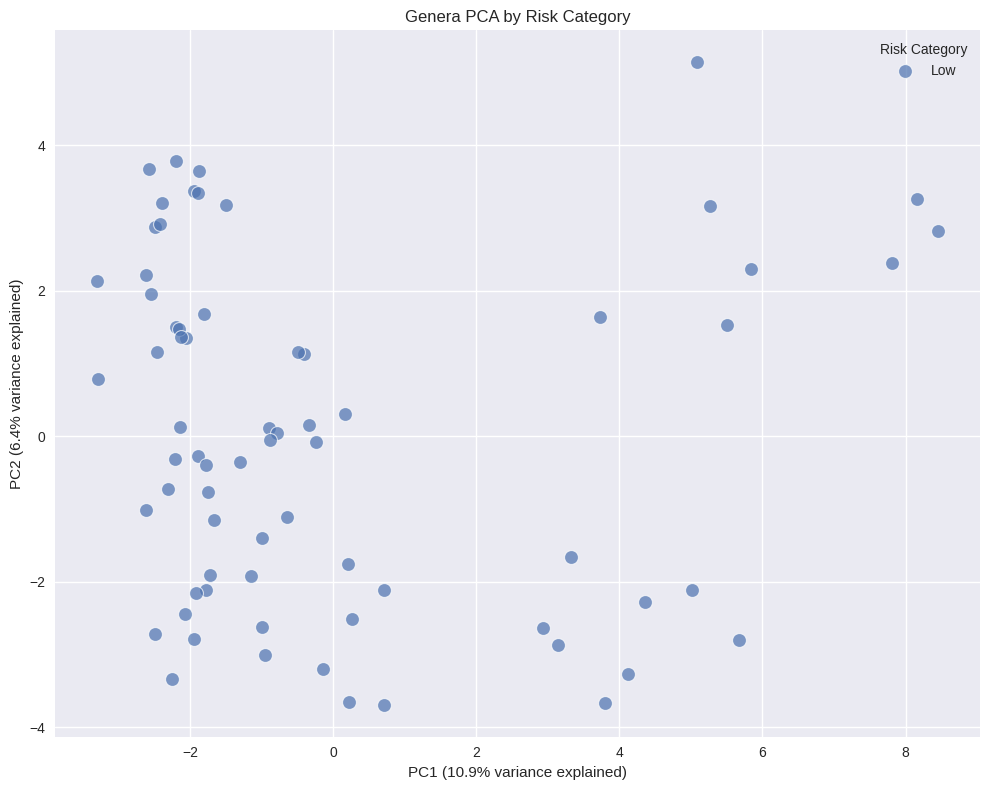

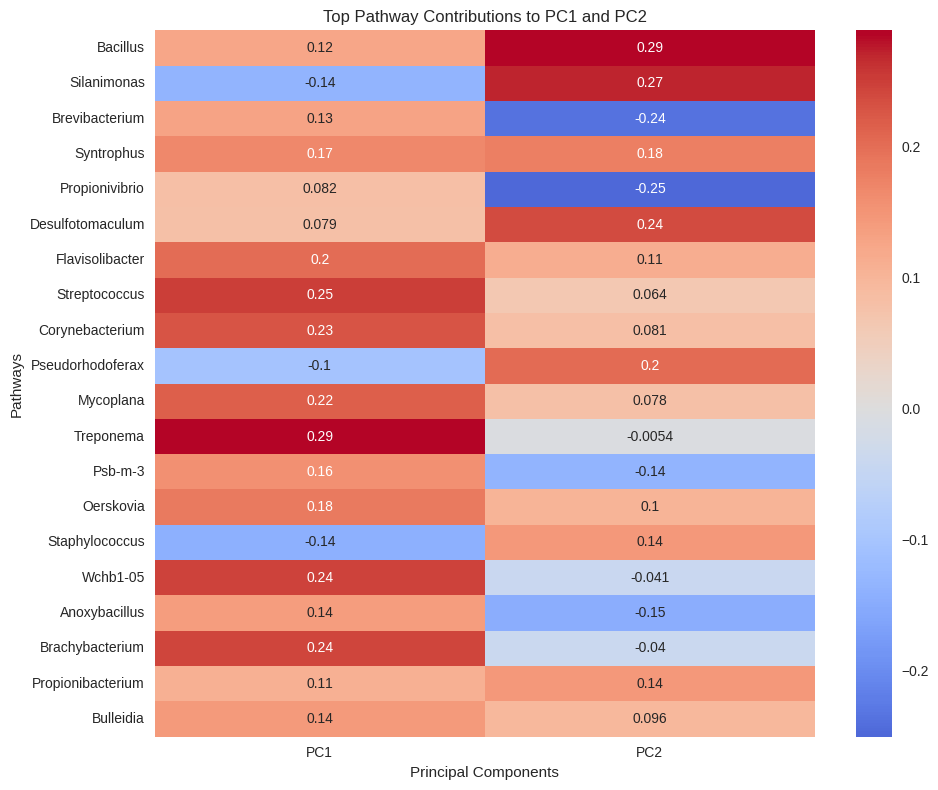

In [ ]:
# For genera PCA
X_pca_genera, var_ratio_genera, loadings_genera = prepare_genera_pca(genera_matrix)
# Get risk categories data
risk_categories = genera_matrix['Risk Category']
plot_pca_results(X_pca_genera, var_ratio_genera, risk_categories,"Genera PCA by Risk Category", category_colors)
plot_pca_loadings_heatmap(loadings_genera)

In [ ]:
# For pathway PCA 
X_pca_path, var_ratio_path, loadings_path = prepare_pathway_pca(metabolic_info)
plot_pca_results(X_pca_path, var_ratio_path, genera_matrix['Risk Category'],"Pathway PCA by Risk Category")
plot_pca_loadings_heatmap(loadings_path)

/tmp/ipykernel_42796/2456046060.py:29: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  pathway_matrix[pathway] = metabolic_info['Pathways'].str.contains(pathway).astype(int)


TypeError: plot_pca_results() missing 1 required positional argument: 'category_colors'

## 9.2 Integrated Visualistaions combining PCA, Clustering and Metadata

In [ ]:
def create_integrated_visualization(df, results, metadata=None):
    """
    Create an integrated visualization combining PCA, clustering, and metadata
    
    Parameters:
    df: Original pathway data
    results: Results from explore_pathway_patterns
    metadata: DataFrame with risk labels, materials, etc.
    """
    fig = plt.figure(figsize=(15, 10))
    
    # 1. PCA with clustering
    pca_data = results['pca']['components']
    clusters = results['clustering'][5]['kmeans']  # Using k=5 clusters
    
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], 
                         c=clusters, cmap='Set2', alpha=0.6)
    plt.title('PCA Components with Clusters')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(scatter, label='Cluster')
    
    # 2. Top pathway contributions
    plt.subplot(2, 2, 2)
    top_loadings = abs(results['pca']['loadings']['PC1']).nlargest(10)
    sns.barplot(x=top_loadings.values, y=top_loadings.index)
    plt.title('Top 10 Pathways Contributing to PC1')
    plt.xlabel('Absolute Loading')
    
    # 3. Correlation structure summary
    plt.subplot(2, 2, 3)
    corr_summary = results['correlation'].abs().mean()
    sns.histplot(corr_summary, bins=50)
    plt.title('Distribution of Mean Correlation Strengths')
    plt.xlabel('Mean |Correlation|')
    
    plt.tight_layout()
    return fig

In [ ]:
create_integrated_visualization(genera_matrix, results_patterns, metadata=None)

KeyError: 'clustering'

<Figure size 1500x1000 with 0 Axes>

## 9.3 Analysing Pathways Organic Fate

Now the task is to identify the most abundant pathways in the samples, focusing specifically on organic matter-related metabolism. Ultimately creating visualizations to understand pathway distributions and analyze correlations between pathways.

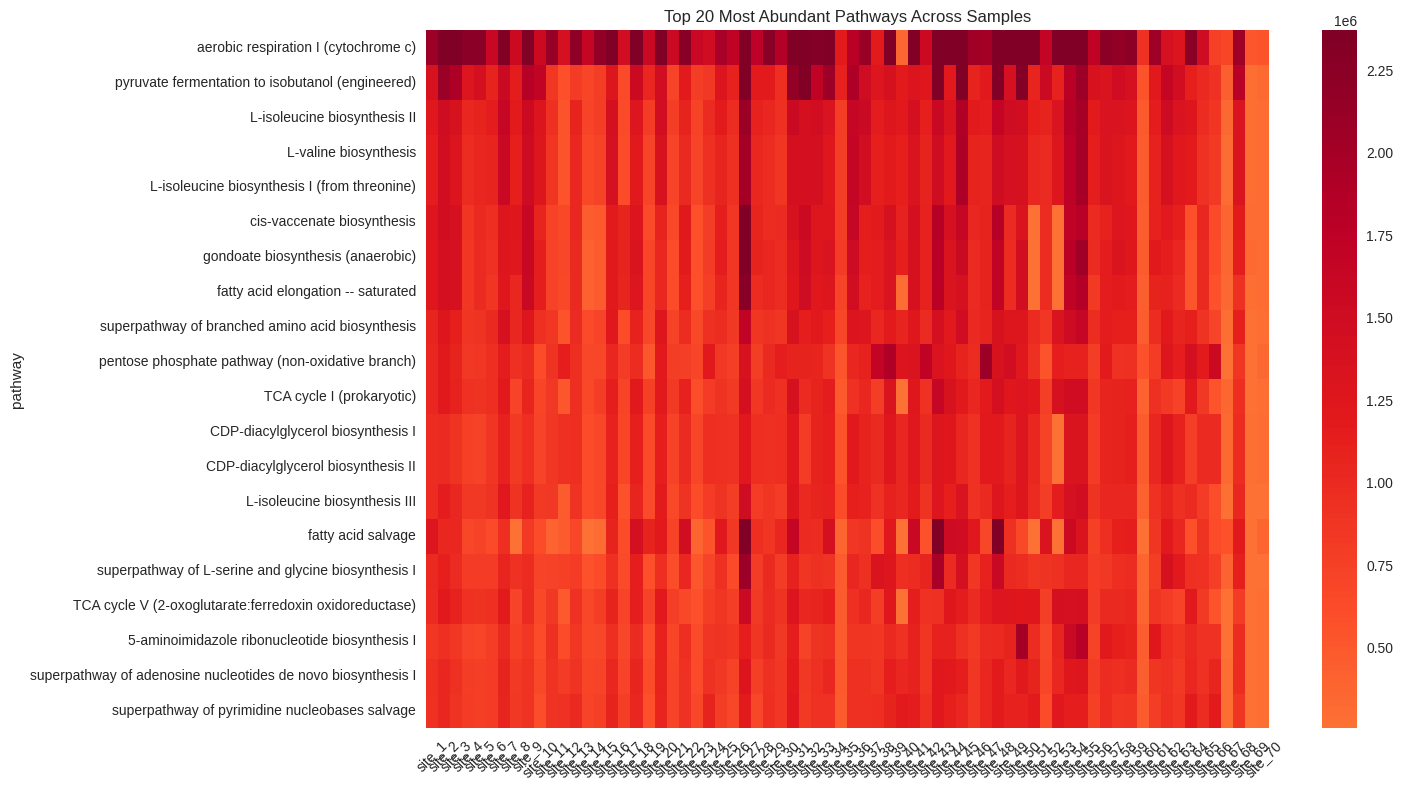

ValueError: Could not interpret input 'index'

<Figure size 1200x600 with 0 Axes>

In [ ]:
def analyze_metabolic_pathways(df):
    """
    Analyze metabolic pathways from PICRUSt output
    
    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Calculate mean abundance across samples for each pathway
    mean_abundance = df.mean(axis=1).sort_values(ascending=False)
    
    # Get top 20 most abundant pathways
    top_pathways = mean_abundance.head(20)
    
    # Create heatmap of top pathways across samples
    plt.figure(figsize=(15, 8))
    sns.heatmap(df.loc[top_pathways.index], 
                cmap='YlOrRd', 
                center=0,
                robust=True,
                xticklabels=True,
                yticklabels=True)
    plt.title('Top 20 Most Abundant Pathways Across Samples')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Filter for organic matter metabolism related pathways
    organic_terms = ['carbon', 'carbohydrate', 'lipid', 'fatty acid', 
                    'organic acid', 'amino acid', 'degradation']
    
    organic_pathways = df.index[df.index.str.lower().str.contains('|'.join(organic_terms))]
    organic_data = df.loc[organic_pathways]
    
    # Calculate summary statistics for organic matter pathways
    pathway_stats = pd.DataFrame({
        'mean_abundance': organic_data.mean(axis=1),
        'std_abundance': organic_data.std(axis=1),
        'cv': organic_data.std(axis=1) / organic_data.mean(axis=1) * 100
    }).sort_values('mean_abundance', ascending=False)
    
    return pathway_stats, organic_data

def plot_pathway_distribution(pathway_stats):
    """Plot distribution of pathway abundances"""
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=pathway_stats.reset_index(), 
                x='mean_abundance', 
                y='index', 
                order=pathway_stats.index[:15])
    plt.title('Top 15 Organic Matter Related Pathways')
    plt.xlabel('Mean Abundance')
    plt.tight_layout()
    plt.show()

# Calling the function 
stats, organic_data = analyze_metabolic_pathways(Picrust_Result)
plot_pathway_distribution(stats)

/tmp/ipykernel_25917/1784301980.py:10: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  specific_data = df.loc[df.index.str.contains('|'.join(pathway_list), case=False)]


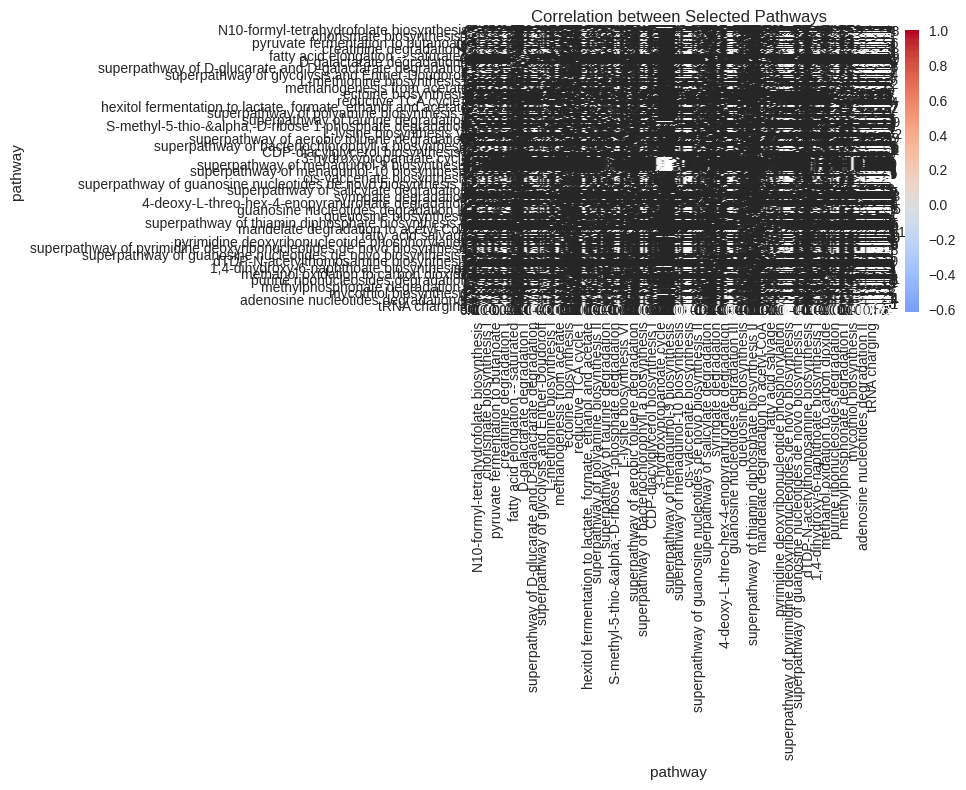

In [ ]:
# To analyze specific pathways of interest:
def analyze_specific_pathways(df, pathway_list):
    """
    Analyze specific pathways of interest
    
    Parameters:
    df: DataFrame with pathway data
    pathway_list: list of pathway names to analyze
    """
    specific_data = df.loc[df.index.str.contains('|'.join(pathway_list), case=False)]
    
    # Create correlation matrix for these pathways
    corr = specific_data.T.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation between Selected Pathways')
    plt.tight_layout()
    plt.show()
    
    return specific_data.describe()

# Calling the funtion
Description = analyze_specific_pathways(Picrust_Result, Picrust_Result.index.tolist())

## 9.4. Pathways Relevant to Corrosion
This code witll categorise pathways into key groups: sulfur metabolism (critical for sulfate-reducing bacteria), Metal-related pathways (iron, manganese, etc.); organic acid production (which can influence local pH); biofilm formation (important for corrosion processes) and eectron transfer mechanisms. Then it would analyse correlations between these different categories to understand potential synergistic effects, identifying the most abundant pathways in each category

In [ ]:
def analyze_corrosion_pathways(df):
    """
    Analyze pathways relevant to microbially influenced corrosion (MIC)
    
    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Define relevant pathway terms for different corrosion mechanisms
    pathway_categories = {
        'sulfur': ['sulfur', 'sulfate', 'sulfide', 'thiosulfate', 'sulfite', 'sulfonate'],
        'metal': ['iron', 'metal', 'Fe', 'manganese', 'chromium', 'nickel'],
        'organic_acid': ['organic acid', 'acetate', 'formate', 'lactate', 'pyruvate'],
        'biofilm': ['biofilm', 'exopolysaccharide', 'EPS', 'adhesion'],
        'electron_transfer': ['cytochrome', 'electron transport', 'oxidoreductase']
    }
    
    # Function to filter pathways by category
    def get_category_pathways(terms):
        return df.index[df.index.str.lower().str.contains('|'.join(terms), regex=True)]
    
    # Analyze each category
    category_data = {}
    category_stats = {}
    
    for category, terms in pathway_categories.items():
        pathways = get_category_pathways(terms)
        if len(pathways) > 0:
            category_data[category] = df.loc[pathways]
            category_stats[category] = pd.DataFrame({
                'mean_abundance': category_data[category].mean(axis=1),
                'std_abundance': category_data[category].std(axis=1),
                'cv': category_data[category].std(axis=1) / category_data[category].mean(axis=1) * 100
            }).sort_values('mean_abundance', ascending=False)
    
    return category_data, category_stats

def plot_corrosion_pathways(category_data, category_stats):
    """
    Create visualizations for corrosion-related pathways
    """
    # Plot top pathways for each category
    for category, data in category_stats.items():
        if len(data) > 0:
            plt.figure(figsize=(12, min(6, max(3, len(data)*0.3))))
            sns.barplot(data=data.head(10).reset_index(), 
                       x='mean_abundance', 
                       y='index',
                       palette='YlOrRd')
            plt.title(f'Top {min(10, len(data))} {category.replace("_", " ").title()} Related Pathways')
            plt.xlabel('Mean Abundance')
            plt.ylabel('Pathway')
            plt.tight_layout()
            plt.show()
    
    # Create correlation heatmap between categories
    category_means = pd.DataFrame({
        cat: data.mean(axis=1) for cat, data in category_data.items()
    })
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(category_means.corr(), 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                vmin=-1, 
                vmax=1)
    plt.title('Correlation between Pathway Categories')
    plt.tight_layout()
    plt.show()

def analyze_pathway_interactions(df, category_data):
    """
    Analyze interactions between different pathway categories
    """
    # Calculate mean abundance for each category
    category_abundances = pd.DataFrame({
        category: data.mean(axis=0) 
        for category, data in category_data.items()
    })
    
    # Calculate correlations between categories
    correlations = category_abundances.corr()
    
    # Identify potential synergistic relationships
    high_correlations = correlations.unstack()
    high_correlations = high_correlations[high_correlations != 1.0]
    high_correlations = high_correlations[abs(high_correlations) > 0.5]
    
    return category_abundances, correlations, high_correlations.sort_values(ascending=False)

# Analysing Corrosion Pathways
category_data, category_stats = analyze_corrosion_pathways(Picrust_Result)
plot_corrosion_pathways(category_data, category_stats)
abundances, correlations, high_corr = analyze_pathway_interactions(Picrust_Result, category_data)

ValueError: Could not interpret input 'index'

<Figure size 1200x300 with 0 Axes>

## 9.5. Heating and Cooling Systems Pathway Analysis
Creating independent analyses:

Failure analysis (based on human assessment/estimation)
Microbiological analysis (16S rRNA)
Physicochemical parameters


Using physicochemical parameters as labels/indicators of corrosion state - this is quite clever because it gives you an objective measure without directly mixing in the biological data
Then planning to correlate the microbial communities with these states through machine learning

And now you want to use PICRUSt's functional predictions to validate your assumptions about organic matter metabolism. This is very valuable because:

It can help confirm if the bacteria you've identified through correlations actually have the metabolic capacity to influence corrosion
It might reveal unexpected metabolic pathways that could explain the correlations you're seeing
The following script will Validate your organic matter assumptions by:

Breaking down different types of organic matter processing
Looking at both degradation and synthesis pathways
Identifying transport mechanisms

Connect with your physicochemical parameters by analyzing pathways that could influence:

pH modulation
Temperature response
Metal interactions

In [ ]:
def analyze_system_pathways(df):
    """
    Analyze pathways relevant to heating/cooling system corrosion
    
    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Define pathway categories relevant to system conditions
    pathway_categories = {
        # Water chemistry influence
        'ph_modulation': ['acid', 'alkaline', 'proton pump', 'pH homeostasis'],
        
        # Temperature adaptation
        'temp_response': ['heat shock', 'cold shock', 'temperature response'],
        
        # Organic matter processing
        'carbon_metabolism': [
            'carbon fixation', 'carbon utilization', 
            'organic acid', 'fatty acid',
            'carbohydrate metabolism'
        ],
        
        # Corrosion-related
        'metal_interaction': [
            'iron', 'metal', 'oxidation-reduction',
            'electron transport', 'metal binding'
        ],
        
        # Biofilm formation
        'surface_attachment': [
            'biofilm', 'adhesion', 'exopolysaccharide',
            'extracellular matrix'
        ]
    }
    
    # Filter and analyze pathways
    def get_category_pathways(terms):
        return df.index[df.index.str.lower().str.contains('|'.join(terms), regex=True)]
    
    category_data = {}
    category_stats = {}
    
    for category, terms in pathway_categories.items():
        pathways = get_category_pathways(terms)
        if len(pathways) > 0:
            category_data[category] = df.loc[pathways]
            
            # Calculate basic statistics
            category_stats[category] = pd.DataFrame({
                'mean_abundance': category_data[category].mean(axis=1),
                'std_abundance': category_data[category].std(axis=1),
                'cv': category_data[category].std(axis=1) / category_data[category].mean(axis=1) * 100,
                'presence': (category_data[category] > 0).mean(axis=1) * 100  # % of samples with pathway
            }).sort_values('mean_abundance', ascending=False)
    
    return category_data, category_stats

def analyze_organic_matter_pathways(df):
    """
    Detailed analysis of organic matter related pathways
    """
    # Specific organic matter categories
    organic_categories = {
        'degradation': ['degradation', 'breakdown', 'catabolism'],
        'synthesis': ['biosynthesis', 'anabolism', 'synthesis'],
        'transport': ['transport', 'uptake', 'export'],
        'modification': ['modification', 'conversion', 'transformation']
    }
    
    organic_data = {}
    
    for category, terms in organic_categories.items():
        pathways = df.index[df.index.str.lower().str.contains(
            '|'.join(terms), regex=True
        ) & df.index.str.lower().str.contains(
            'organic|carbon|fatty acid|lipid|protein|amino acid'
        )]
        if len(pathways) > 0:
            organic_data[category] = df.loc[pathways]
    
    return organic_data

def plot_pathway_distributions(category_stats, category_data):
    """
    Create visualizations for pathway distributions
    """
    for category, stats in category_stats.items():
        if len(stats) > 0:
            # Create subplot with dual axis
            fig, ax1 = plt.subplots(figsize=(12, min(8, max(4, len(stats)*0.3))))
            ax2 = ax1.twinx()
            
            # Plot mean abundance
            sns.barplot(data=stats.head(10).reset_index(), 
                       x='mean_abundance', 
                       y='index',
                       color='skyblue',
                       ax=ax1)
            
            # Plot presence percentage
            stats.head(10)['presence'].plot(
                marker='o', 
                color='red',
                ax=ax2
            )
            
            ax1.set_title(f'{category.replace("_", " ").title()} Pathways')
            ax1.set_xlabel('Mean Abundance')
            ax2.set_xlabel('Presence (%)')
            
            plt.tight_layout()
            plt.show()

# Calling the analysis
category_data, category_stats = analyze_system_pathways(Picrust_Result)
organic_data = analyze_organic_matter_pathways(Picrust_Result)
plot_pathway_distributions(category_stats, category_data)

I have a big gap on the cation anion account and then used mackensy, 2012 method from the usgs to check ec measured Vs calculated and cation Vs ions. It is a big gap still, but I have a lot of OM so I could no assume as normally that OM is CH4 so I attribute it to small organic acids and put acetate and oxalate as OM representatives, I have a small study of small acids form on failure analysis and also report of a mass that has a magnetic consistency, so I infere that those muss be some organic metalic compound but only accounted for AC- and Ox-2, I thought better to chose this other compounds Fe rich but I don't know how to do it actually. So in my bacteria I actually found lots of them with Ac- metabolism whiles I was looking at the families I realise no only oxobacter accendants, but others similar, also got important biofilm formers, there is also halogen related and should be, big deal of difference make the material and location cause water treatment, unfortunately the annotations are no to be taken as parameters but can serve as annotations you understand the difference?

validate assumptions about:

Organic acid presence (by showing metabolic capability)
Metal-organic complex formation (through siderophore and metal-binding pathways)
Biofilm formation potential (which can influence local chemistry)

Validate acetate/oxalate assumptions by showing if these metabolic pathways are actually present
Look for other potential organic acid pathways might want to consider
Identify metal-organic interaction pathways that could explain magnetic mass observation

In [ ]:
def analyze_organic_metal_pathways(df):
    """
    Analyze pathways related to organic acid metabolism and metal interactions
    
    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Define specific pathway categories
    pathway_categories = {
        'organic_acid_metabolism': [
            'acetate', 'acetic acid', 'acetyl',
            'oxalate', 'oxalic acid',
            'organic acid', 'fatty acid',
            'carboxylic acid'
        ],
        
        'metal_organic_interaction': [
            'siderophore', 'metal binding',
            'iron complex', 'metal transport',
            'metallophore', 'metal organic'
        ],
        
        'biofilm_formation': [
            'biofilm', 'exopolysaccharide',
            'extracellular matrix', 'adhesion'
        ],
        
        'halogen_related': [
            'halogen', 'chloride', 'bromide',
            'halide', 'dehalogenation'
        ]
    }
    
    # Analyze each category
    def get_category_pathways(terms):
        return df.index[df.index.str.lower().str.contains('|'.join(terms), regex=True)]
    
    pathway_data = {}
    pathway_stats = {}
    
    for category, terms in pathway_categories.items():
        pathways = get_category_pathways(terms)
        if len(pathways) > 0:
            pathway_data[category] = df.loc[pathways]
            
            # Calculate comprehensive statistics
            pathway_stats[category] = pd.DataFrame({
                'mean_abundance': pathway_data[category].mean(axis=1),
                'std_abundance': pathway_data[category].std(axis=1),
                'cv': pathway_data[category].std(axis=1) / pathway_data[category].mean(axis=1) * 100,
                'presence': (pathway_data[category] > 0).mean(axis=1) * 100,  # % of samples with pathway
                'relative_abundance': pathway_data[category].mean(axis=1) / df.mean(axis=1).mean() * 100
            }).sort_values('mean_abundance', ascending=False)
    
    return pathway_data, pathway_stats

def analyze_pathway_relationships(pathway_data):
    """
    Analyze relationships between different pathway categories
    """
    # Calculate mean abundance for each category across samples
    category_means = pd.DataFrame({
        category: data.mean(axis=0) 
        for category, data in pathway_data.items()
    })
    
    # Calculate correlations
    correlations = category_means.corr()
    
    # Identify potential functional relationships
    high_correlations = correlations.unstack()
    high_correlations = high_correlations[high_correlations != 1.0]
    high_correlations = high_correlations[abs(high_correlations) > 0.5]
    
    return category_means, correlations, high_correlations.sort_values(ascending=False)

def plot_pathway_analysis(pathway_stats, pathway_data):
    """
    Create visualizations for pathway analysis
    """
    for category, stats in pathway_stats.items():
        if len(stats) > 0:
            # Create subplot with dual axis
            fig, ax1 = plt.subplots(figsize=(12, min(8, max(4, len(stats)*0.3))))
            ax2 = ax1.twinx()
            
            # Plot abundance and relative abundance
            sns.barplot(data=stats.head(10).reset_index(), 
                       x='relative_abundance', 
                       y='index',
                       color='skyblue',
                       ax=ax1)
            
            stats.head(10)['presence'].plot(
                marker='o', 
                color='red',
                ax=ax2
            )
            
            ax1.set_title(f'{category.replace("_", " ").title()} Pathways')
            ax1.set_xlabel('Relative Abundance (%)')
            ax2.set_xlabel('Presence (%)')
            
            plt.tight_layout()
            plt.show()

# calling the function
pathway_data, pathway_stats = analyze_organic_metal_pathways(Picrust_Result)category_means, correlations, high_corr = analyze_pathway_relationships(pathway_data)
plot_pathway_analysis(pathway_stats, pathway_data)

## 9.6. Corrosion Relevant Pathways

Focus on corrosion-relevant pathways by categorizing them into:

Organic acid metabolism (relevant to your acetate/oxalate observations)
Sulfur metabolism
Metal interactions
Biofilm formation


Handle the high-dimensional data by:

Using dimensionality reduction (PCA)
Calculating summary statistics
Visualizing key patterns


Address your specific interests:

Organic matter metabolism pathways
Metal-organic interactions
Correlations with physicochemical parameters

In [ ]:
def analyze_corrosion_pathways(df):
    """
    Analyze pathways relevant to microbially influenced corrosion
    """
    # Define pathway categories relevant to corrosion
    pathway_categories = {
        'organic_acid': [
            'CENTFERM-PWY',  # Central fermentation pathways
            'FERMENTATION-PWY',  # Mixed acid fermentation
            'GLYCOLYSIS',  # Glucose fermentation
            'PWY-5100',  # Pyruvate fermentation
            'GALACTUROCAT-PWY'  # Galacturonate degradation
        ],
        'sulfur': [
            'PWY-6932',  # Sulfate reduction
            'SO4ASSIM-PWY',  # Sulfate assimilation
            'SULFATE-CYS-PWY'  # Sulfate to cysteine
        ],
        'metal_interaction': [
            'PWY-7219',  # Iron oxidation
            'PWY-7221',  # Iron reduction
            'HEME-BIOSYNTHESIS-II',  # Iron-containing compounds
            'P125-PWY'  # Metal resistance
        ],
        'biofilm': [
            'COLANSYN-PWY',  # Colanic acid (biofilm)
            'EXOPOLYSACC-PWY',  # Exopolysaccharide
            'GLUCOSE1PMETAB-PWY'  # UDP-glucose synthesis
        ]
    }
    
    # Extract relevant pathways and their abundances
    relevant_pathways = {}
    for category, pathways in pathway_categories.items():
        category_data = df[df.index.isin(pathways)]
        if not category_data.empty:
            relevant_pathways[category] = category_data
    
    # Calculate summary statistics
    summary_stats = {}
    for category, data in relevant_pathways.items():
        summary_stats[category] = {
            'mean_abundance': data.mean().mean(),
            'std_abundance': data.mean().std(),
            'present_in_samples': (data > 0).mean().mean() * 100,
            'pathways_found': len(data)
        }
    
    # Dimension reduction for visualization
    if df.shape[0] > 0:
        # Standardize the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(df.T)
        
        # PCA
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_data)
        
        return relevant_pathways, summary_stats, pca_result, pca.explained_variance_ratio_
    
    return relevant_pathways, summary_stats, None, None

def plot_pathway_analysis(relevant_pathways, summary_stats, pca_result=None, explained_variance=None):
    """
    Create visualizations for pathway analysis
    """
    # Plot mean abundances by category
    plt.figure(figsize=(12, 6))
    categories = list(summary_stats.keys())
    means = [stats['mean_abundance'] for stats in summary_stats.values()]
    presence = [stats['present_in_samples'] for stats in summary_stats.values()]
    
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    bars = ax1.bar(categories, means, alpha=0.6, color='skyblue')
    ax1.set_ylabel('Mean Abundance')
    
    line = ax2.plot(categories, presence, 'ro-', label='Presence %')
    ax2.set_ylabel('Presence in Samples (%)')
    
    plt.title('Pathway Categories Overview')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # If PCA results available, plot them
    if pca_result is not None:
        plt.figure(figsize=(10, 8))
        plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
        plt.xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)')
        plt.title('PCA of Pathway Abundances')
        plt.tight_layout()
        plt.show()

# Calling the functions
relevant_pathways, summary_stats, pca_result, explained_variance = analyze_corrosion_pathways(Picrust_Result)
plot_pathway_analysis(relevant_pathways, summary_stats, pca_result, explained_variance)

## 9.7. Functional Pathway Clustering Analysis
Hierarchical Clustering:

Groups pathways based on their abundance patterns
Creates a dendrogram to visualize relationships
Automatically determines optimal number of clusters


Correlation-based Analysis:

Identifies pathways that behave similarly across samples
Creates correlation heatmap to visualize relationships
Helps identify functional modules


Feature Creation:

Generates new features based on cluster statistics:

Mean abundance per cluster
Total abundance per cluster
Pathway diversity within clusters

Reduce dimensionality while maintaining biological meaning
Identify functional modules that might be working together
Create more robust features for your ML analysis

In [ ]:
def cluster_pathways(df, n_clusters=None, corr_threshold=0.7):
    """
    Cluster pathways based on their functional similarity
    
    Parameters:
    df: DataFrame with pathways as rows and samples as columns
    n_clusters: Number of clusters (if None, determined automatically)
    corr_threshold: Correlation threshold for considering pathways related
    """
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df.T).T
    
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(scaled_data)
    
    # Create linkage matrix for hierarchical clustering
    linkage_matrix = hierarchy.linkage(pdist(scaled_data), method='ward')
    
    if n_clusters is None:
        # Automatically determine number of clusters using elbow method
        last = linkage_matrix[-10:, 2]
        acceleration = np.diff(last, 2)
        n_clusters = len(last) - np.argmax(acceleration) + 1
    
    # Perform clustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clustering.fit_predict(scaled_data)
    
    # Create cluster summary
    cluster_summary = pd.DataFrame({
        'pathway': df.index,
        'cluster': cluster_labels
    })
    
    return cluster_labels, linkage_matrix, corr_matrix, cluster_summary

def analyze_pathway_clusters(df, cluster_labels):
    """
    Analyze the characteristics of each pathway cluster
    """
    cluster_stats = {}
    
    for cluster in np.unique(cluster_labels):
        # Get pathways in this cluster
        cluster_paths = df.index[cluster_labels == cluster]
        cluster_data = df.loc[cluster_paths]
        
        # Calculate statistics
        cluster_stats[cluster] = {
            'size': len(cluster_paths),
            'mean_abundance': cluster_data.mean().mean(),
            'std_abundance': cluster_data.mean().std(),
            'pathways': list(cluster_paths),
            'correlation': np.corrcoef(cluster_data),
            'total_abundance': cluster_data.sum().mean()
        }
    
    return cluster_stats

def plot_pathway_clusters(df, linkage_matrix, corr_matrix, cluster_labels, cluster_stats):
    """
    Create visualizations for pathway clusters
    """
    # Plot dendrogram
    plt.figure(figsize=(15, 10))
    plt.title('Pathway Clustering Dendrogram')
    hierarchy.dendrogram(linkage_matrix, labels=df.index, leaf_rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 12))
    sns.heatmap(pd.DataFrame(corr_matrix, index=df.index, columns=df.index),
                cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title('Pathway Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    # Plot cluster sizes and abundances
    plt.figure(figsize=(12, 6))
    clusters = list(cluster_stats.keys())
    sizes = [stats['size'] for stats in cluster_stats.values()]
    abundances = [stats['mean_abundance'] for stats in cluster_stats.values()]
    
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    ax1.bar(clusters, sizes, alpha=0.6, color='skyblue')
    ax1.set_ylabel('Number of Pathways')
    
    ax2.plot(clusters, abundances, 'ro-')
    ax2.set_ylabel('Mean Abundance')
    
    plt.title('Cluster Sizes and Abundances')
    plt.tight_layout()
    plt.show()

def create_cluster_features(df, cluster_labels):
    """
    Create new features based on pathway clusters
    """
    n_clusters = len(np.unique(cluster_labels))
    cluster_features = pd.DataFrame(index=df.columns)
    
    for cluster in range(n_clusters):
        # Get pathways in this cluster
        cluster_paths = df.index[cluster_labels == cluster]
        
        # Calculate mean abundance for cluster
        cluster_features[f'cluster_{cluster}'] = df.loc[cluster_paths].mean()
        
        # Calculate total abundance for cluster
        cluster_features[f'cluster_{cluster}_total'] = df.loc[cluster_paths].sum()
        
        # Calculate diversity within cluster
        cluster_features[f'cluster_{cluster}_diversity'] = (df.loc[cluster_paths] > 0).sum()
    
    return cluster_features

# Calling the fUNCTION
cluster_labels, linkage_matrix, corr_matrix, cluster_summary = cluster_pathways(Picrust_Result)
cluster_stats = analyze_pathway_clusters(Picrust_Result, cluster_labels)
plot_pathway_clusters(Picrust_Result, linkage_matrix, corr_matrix, cluster_labels, cluster_stats)
cluster_features = create_cluster_features(Picrust_Result, cluster_labels)

I dont know hte gfollowinag

In [ ]:

def analyze_organic_metal_pathways(df):
    """
    Analyze pathways related to organic acid metabolism and metal interactions
    
    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Define specific pathway categories
    pathway_categories = {
        'organic_acid_metabolism': [
            'acetate', 'acetic acid', 'acetyl',
            'oxalate', 'oxalic acid',
            'organic acid', 'fatty acid',
            'carboxylic acid'
        ],
        
        'metal_organic_interaction': [
            'siderophore', 'metal binding',
            'iron complex', 'metal transport',
            'metallophore', 'metal organic'
        ],
        
        'biofilm_formation': [
            'biofilm', 'exopolysaccharide',
            'extracellular matrix', 'adhesion'
        ],
        
        'halogen_related': [
            'halogen', 'chloride', 'bromide',
            'halide', 'dehalogenation'
        ]
    }
    
    # Analyze each category
    def get_category_pathways(terms):
        return df.index[df.index.str.lower().str.contains('|'.join(terms), regex=True)]
    
    pathway_data = {}
    pathway_stats = {}
    
    for category, terms in pathway_categories.items():
        pathways = get_category_pathways(terms)
        if len(pathways) > 0:
            pathway_data[category] = df.loc[pathways]
            
            # Calculate comprehensive statistics
            pathway_stats[category] = pd.DataFrame({
                'mean_abundance': pathway_data[category].mean(axis=1),
                'std_abundance': pathway_data[category].std(axis=1),
                'cv': pathway_data[category].std(axis=1) / pathway_data[category].mean(axis=1) * 100,
                'presence': (pathway_data[category] > 0).mean(axis=1) * 100,  # % of samples with pathway
                'relative_abundance': pathway_data[category].mean(axis=1) / df.mean(axis=1).mean() * 100
            }).sort_values('mean_abundance', ascending=False)
    
    return pathway_data, pathway_stats

def analyze_pathway_relationships(pathway_data):
    """
    Analyze relationships between different pathway categories
    """
    # Calculate mean abundance for each category across samples
    category_means = pd.DataFrame({
        category: data.mean(axis=0) 
        for category, data in pathway_data.items()
    })
    
    # Calculate correlations
    correlations = category_means.corr()
    
    # Identify potential functional relationships
    high_correlations = correlations.unstack()
    high_correlations = high_correlations[high_correlations != 1.0]
    high_correlations = high_correlations[abs(high_correlations) > 0.5]
    
    return category_means, correlations, high_correlations.sort_values(ascending=False)

def plot_pathway_analysis(pathway_stats, pathway_data):
    """
    Create visualizations for pathway analysis
    """
    for category, stats in pathway_stats.items():
        if len(stats) > 0:
            # Create subplot with dual axis
            fig, ax1 = plt.subplots(figsize=(12, min(8, max(4, len(stats)*0.3))))
            ax2 = ax1.twinx()
            
            # Plot abundance and relative abundance
            sns.barplot(data=stats.head(10).reset_index(), 
                       x='relative_abundance', 
                       y='index',
                       color='skyblue',
                       ax=ax1)
            
            stats.head(10)['presence'].plot(
                marker='o', 
                color='red',
                ax=ax2
            )
            
            ax1.set_title(f'{category.replace("_", " ").title()} Pathways')
            ax1.set_xlabel('Relative Abundance (%)')
            ax2.set_xlabel('Presence (%)')
            
            plt.tight_layout()
            plt.show()

ValueError: Could not interpret input 'index'

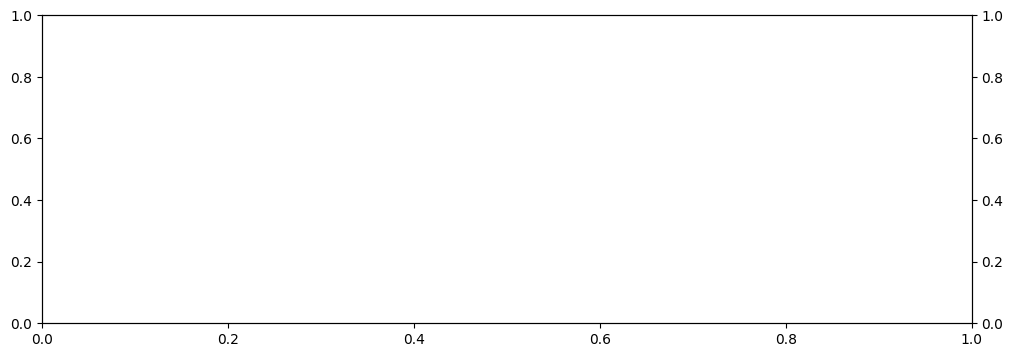

In [ ]:
# Calling the function
pathway_data, pathway_stats = analyze_organic_metal_pathways(Picrust_Result)
category_means, correlations, high_corr = analyze_pathway_relationships(pathway_data)
plot_pathway_analysis(pathway_stats, pathway_data)